# **Feature Peaks PLS**

This notebook is for the analysis of the data that are produced from peaks_PLS.py. 

It is divided into:
1. **Concatenated movie:**
- Emotions peaks
- Peaks from features extracted
- Mean of the peaks from features extracted
2. **Single movie:**
- Emotions peaks
- Peaks from features extracted
- Mean of the peaks from emotions (normalized)
- Scaffolds and Triangles
- Functional Networks for BOLD, Scaffolds and Triangles


### **Importing the libraries and defining the functions**

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers_PLS import *
from statannotations.Annotator import Annotator

Set the names of the Movies and the emotions that are being considered

In [2]:
emotions = ['WarmHeartedness', 'Happiness', 'Sad', 'Anxiety', 'Love', 'Fear', 'Regard']
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']
thresholds = [1, 1.5, 2]

In [50]:
def retrieve_significant(peaks_data, data_all_movie):

    # Take the significant LC for the PLS on the peaks
    significant_peaks = peaks_data[peaks_data['P-value'] < 0.05]
    significant_peaks = significant_peaks.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold']).sum()['Covariance Explained'].reset_index()
    significant_peaks['Covariance Explained'] = significant_peaks['Covariance Explained']
    significant_peaks['Control'] = significant_peaks['Feature'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
    significant_peaks['Feature'] = significant_peaks['Feature'].apply(lambda x: x.split('_')[-1])
    significant_peaks['Feature'] = significant_peaks['Feature'].apply(lambda x: 'average_' + x if x in ['brightness', 'saturation', 'hue'] else x)

    # Take the significant LC for the PLS on all the movie
    data_all_movie['Feature'] = 'All movie'
    if 'Number of points' not in data_all_movie.columns:
        data_all_movie['Number of points'] = 7000
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Region', 'Feature', 'Number of points', 'bootstrap_round']).sum()['Covariance Explained'].reset_index()
    significant_all_movie['Control'] = 0

    # Merge the dataframes
    significant = pd.concat([significant_peaks, significant_all_movie], ignore_index=True)

    significant.loc[significant['Feature'] == 'All movie', 'Number of points'] = 7000
    return significant

def increase_thr(significant, order_emotions, pairs = None, order_hue = None, on = 'Number of points', title = 'Covariance explained for the different emotions for different number of points'):

    # Define your thresholds
    palette = sns.color_palette("Set2", 8)[3:8]

    # Assuming 'significant' is your DataFrame and 'emotions' is defined
    order_emotions = emotions.append('All movie')
    df = significant[significant['Control'] == 0]

    # Plot
    plt.figure(figsize=(15, 10))
    sns.boxplot(x='Feature', y='Covariance Explained', data=df,  hue=on, palette=palette, order=order_emotions, hue_order=order_hue)
    plt.xlabel('Emotions', fontsize=20)
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=17)
    plt.axhline(y=significant[significant['Feature'] == 'All movie']['Covariance Explained'].median(), color='r', linestyle='--', label='All movie median')
    plt.ylim(0, 1)

    # Annotate
    if pairs is not None:
        annotator = Annotator(ax, pairs, data=df ,x='Feature', y='Covariance Explained', hue='Number of points')
        annotator.configure(test='Wilcoxon',text_format='star',loc='inside',comparisons_correction='BH',correction_format='replace')
        annotator.apply_and_annotate()

    plt.tight_layout()
    plt.show()

def plot_peaks_pts(significant, thresholds, on = 'Number of points'):

    palette = sns.color_palette("Set2", 2)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))  # Adjust the size as needed
    for i, thr in enumerate(thresholds):
        significant.loc[significant['Feature'] == 'All movie', on] = thr
        df_thr = significant[significant[on] == thr]

        # sns.boxplot(x='Feature', y='Covariance Explained', data=df_thr,  hue='Control', ax=axes[i], palette=palette,
        #             order = ['All movie', 'Happiness', 'Love', 'WarmHeartedness', 'Regard', 'Sad', 'Anxiety', 'Fear'])
        
        sns.boxplot(data=df_thr, x="Feature", y="Covariance Explained", hue="Control", ax=axes[i], palette=palette)

        axes[i].set_title(f'Concatenated movies - {on} {thr}', fontsize=20)
        axes[i].set_ylim(0, 1)
        axes[i].set_xlabel('Features', fontsize=25)
        axes[i].set_ylabel('Covariance Explained', fontsize=25)
        # font size of the x and y ticks 
        axes[i].tick_params(axis='both', which='major', labelsize=20, rotation=90)
        axes[i].tick_params(axis='both', which='minor', labelsize=20, rotation=90)
        axes[i].axhline(y=significant[significant['Feature'] == 'All movie']['Covariance Explained'].median(), color='r', linestyle='--', label='All movie median')


    plt.tight_layout()
    # delete plot
    plt.show()

def threshold_from_df(concatmovies = 'concat'):
    PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_{concatmovies}_pts.csv'
    peaks_data = pd.read_csv(PATH)
    features = [x for x in peaks_data.Feature.unique() if not x.startswith('Control')]
    thresholds = {}
    for feature in features:
        thresholds[feature] = peaks_data[peaks_data['Feature'] == feature]['threshold'].unique()
    return thresholds

def concat_emo(server = True):
    list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']
    data_concat = pd.DataFrame()
    for movie_name in list_movies:
        if server == True:
            PATH  = '/media/miplab-nas2/Data2/Movies_Emo/Flavia_E3/EmoData'
        else:
            PATH = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData'
        labels = pd.read_json(PATH + f'/Annot13_{movie_name}_stim.json')
        data = pd.read_csv(PATH + f'/Annot13_{movie_name}_stim.tsv', sep = '\t', header = None)
        data.columns = labels['Columns']
        data_concat = pd.concat([data_concat, data], axis=0)
    data_concat.reset_index(drop=True, inplace=True)
    print('The shape of the data_concat is: ', data_concat.shape)
    return data_concat

## **Emotions peaks**

Counting points function is used to count the number of peaks in each emotion.

In [32]:
count_pts = counting_points(list_movies, thresholds, emotions)
print(count_pts)

{1: {'WarmHeartedness': 769, 'Happiness': 512, 'Sad': 946, 'Anxiety': 833, 'Love': 729, 'Fear': 724, 'Regard': 583, 'All Movie': 7385}, 1.5: {'WarmHeartedness': 397, 'Happiness': 221, 'Sad': 548, 'Anxiety': 475, 'Love': 345, 'Fear': 379, 'Regard': 323, 'All Movie': 7385}, 2: {'WarmHeartedness': 189, 'Happiness': 101, 'Sad': 243, 'Anxiety': 245, 'Love': 46, 'Fear': 217, 'Regard': 42, 'All Movie': 7385}}


Read the data on the peaks for the concatenated movie.

In [33]:
# Read the data of the PLS calculated on the peaks of the emotions  for the concatenated movies
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_concat.csv').dropna(inplace=False)

# Select only the data from whole brain
peaks_data = peaks_data[peaks_data['Region'] == 'ALL']

# Read the data for the PLS computed on all the movies concatenated
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])
data_all['Region'] = 'ALL'
data_all['Type'] = 'bold'
data_all.reset_index(inplace=True, drop=False)
data_all.rename(columns={'index': 'bootstrap_round'}, inplace=True)

The shape of the data_concat is:  (7385, 50)


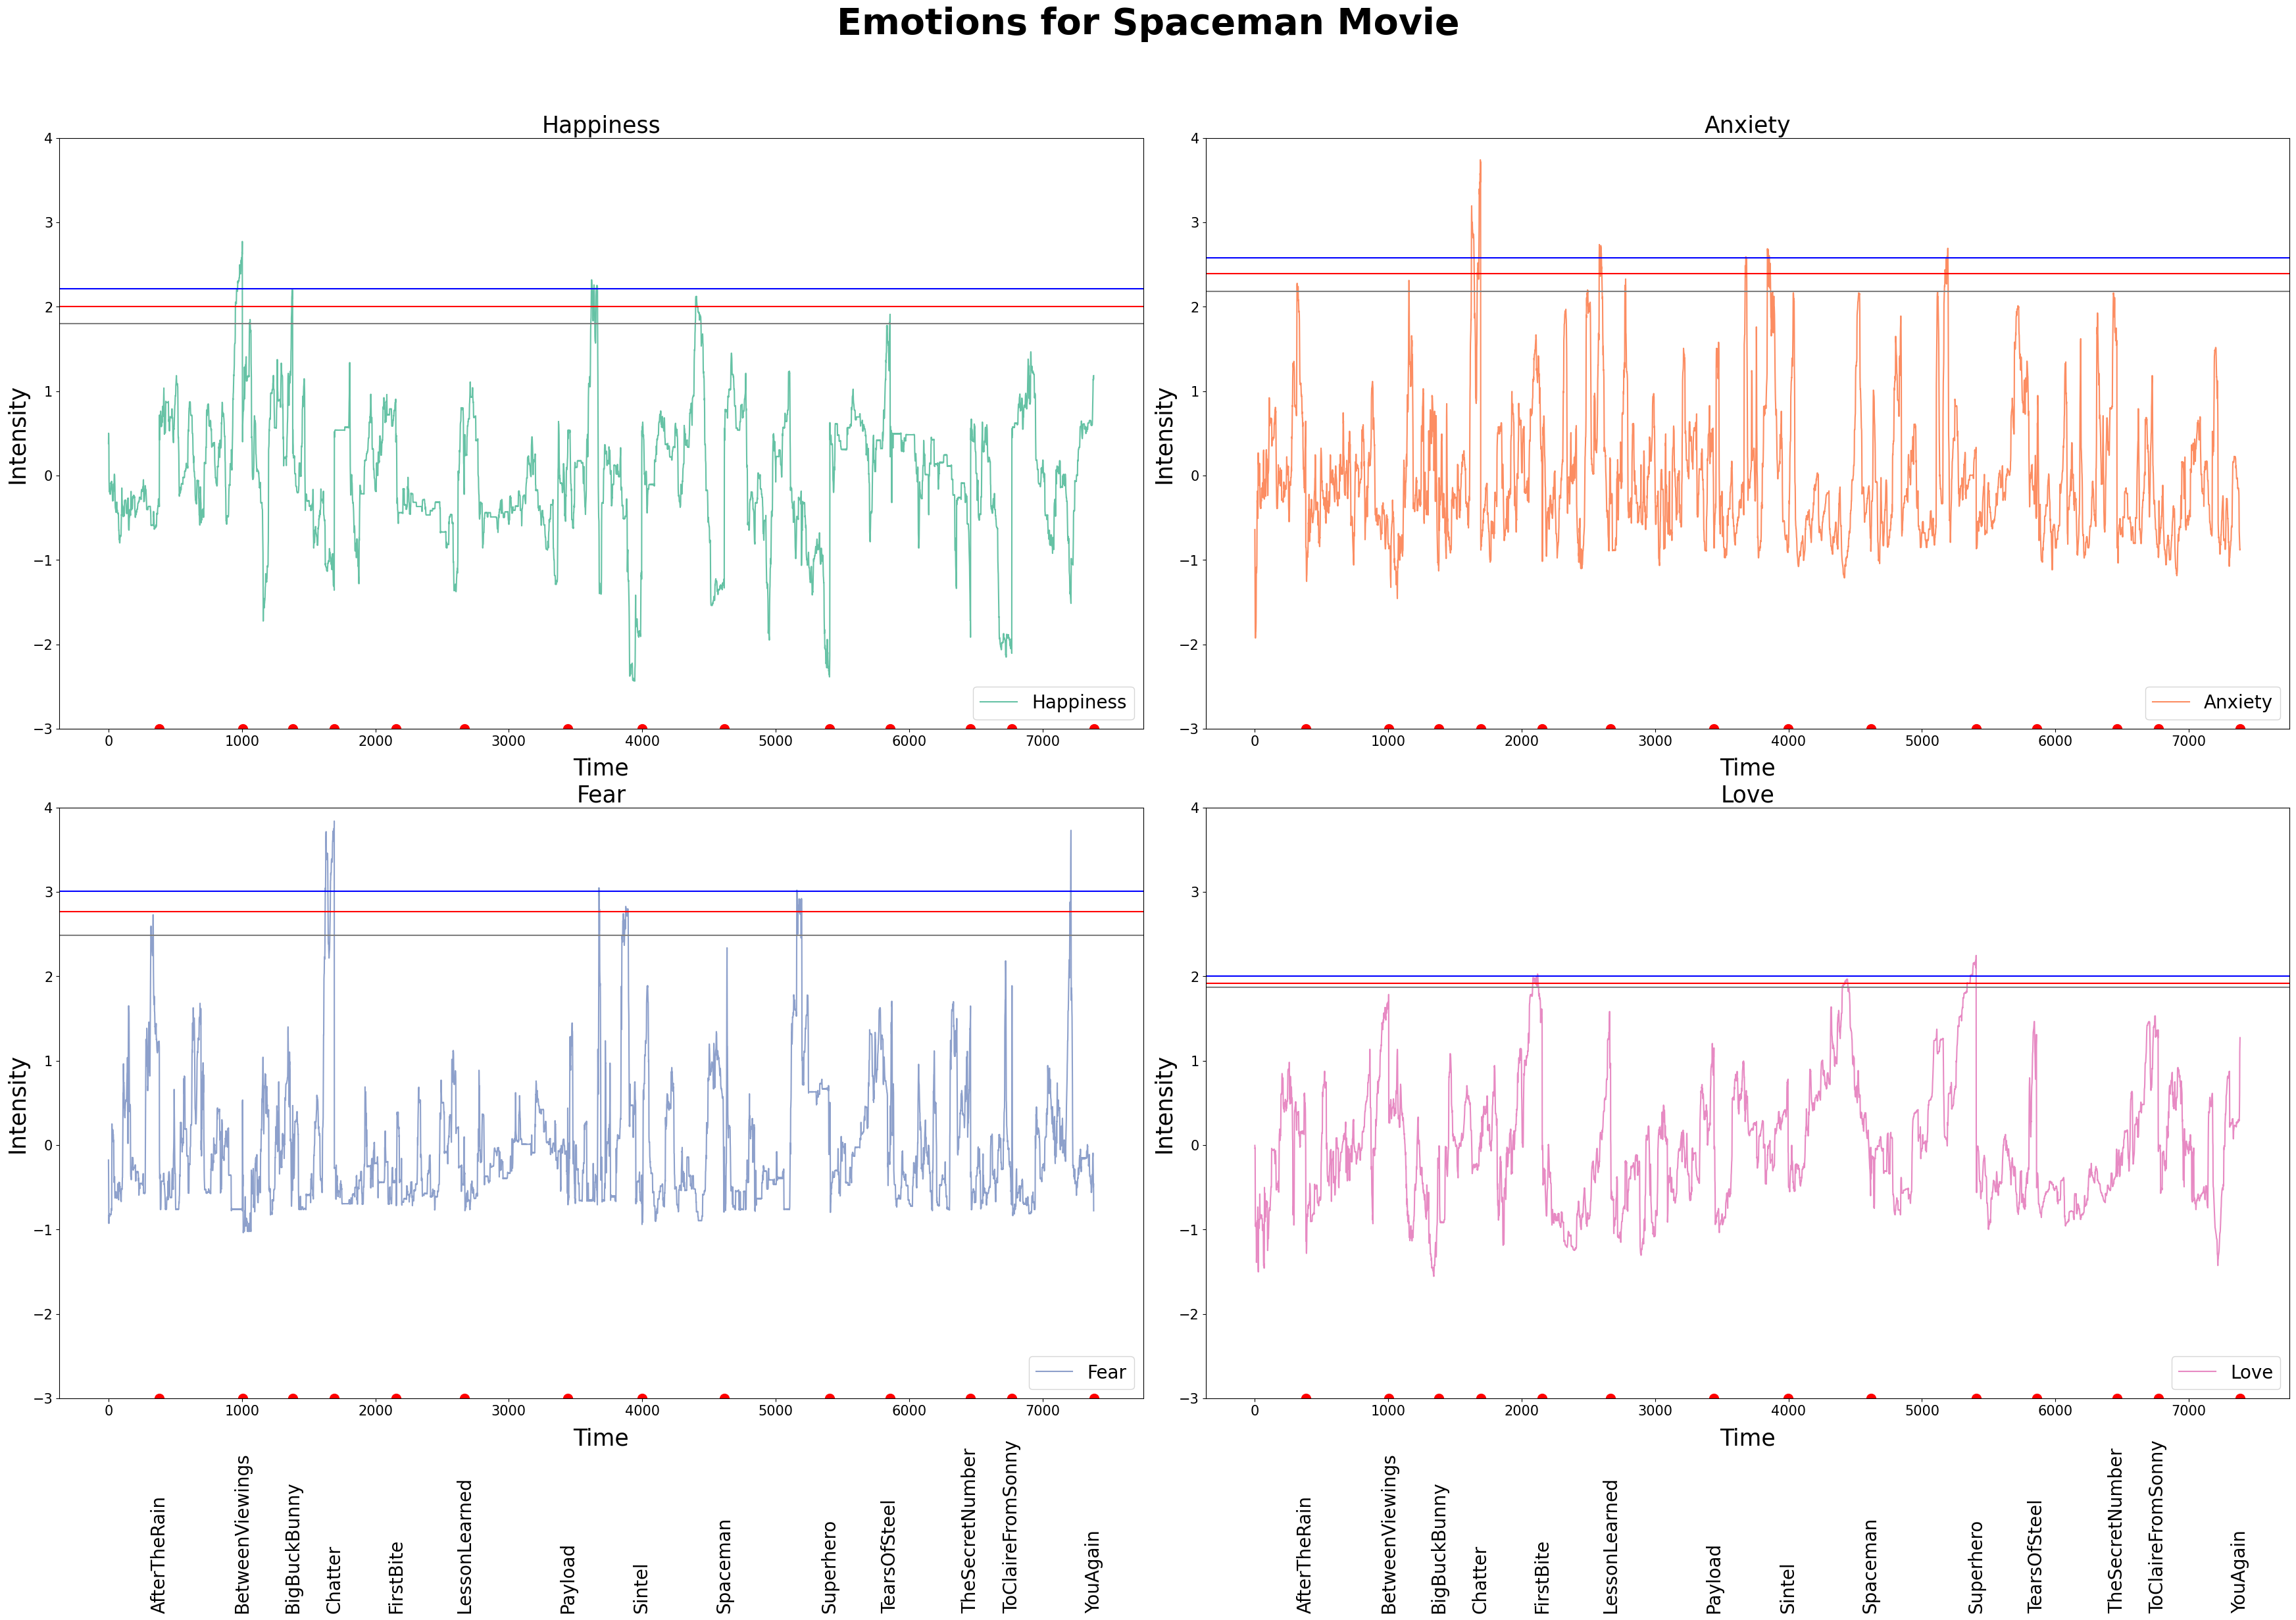

In [35]:
concat_emo = concat_emo(server = False)
emotions = ['Happiness', 'Anxiety', 'Fear', 'Love']
palette = sns.color_palette("Set2", len(emotions))

# Determine the layout of the subplot
n_rows = int(len(emotions) ** 0.5)
n_cols = int(len(emotions) / n_rows) + (len(emotions) % n_rows > 0)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(35, 25))  # Adjust figsize as needed
#fig.suptitle('Emotions for the Concatenated Movies', fontsize=40, fontweight='bold')
fig.suptitle('Emotions for Spaceman Movie', fontsize=40, fontweight='bold')

for i, emotion in enumerate(emotions):
    # Determine the current subplot row and column
    row = i // n_cols
    col = i % n_cols
    if n_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]

    # Plot the data
    ax.plot(concat_emo[emotion], label=emotion, color=palette[i])
    ax.set_title(emotion, fontsize=25)
    ax.set_xlabel('Time', fontsize=25, labelpad=10)
    ax.set_ylabel('Intensity', fontsize=25)
    ax.legend(loc='lower right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylim([-3, 4])

    # Plot the thresholds
    thresholds = threshold_from_df(concatmovies = 'concat')
    ax.axhline(y=thresholds[emotion][0], color='grey', linestyle='-', label='150 points')
    ax.axhline(y=thresholds[emotion][1], color='red', linestyle='-', label='100 points')
    if emotion != 'Regard':
        ax.axhline(y=thresholds[emotion][2], color='blue', linestyle='-', label='35 points')
    
    # Add the movie names
    for movie in list_movies:
        ax.plot(lenght_movies[movie], -3, marker='o', color='red', markersize=10)
        if row == 1:
            ax.text(lenght_movies[movie], -5.5, movie, ha='center', fontsize=20, rotation=90)

# Adjustments to the layout of the subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9)  

plt.show()

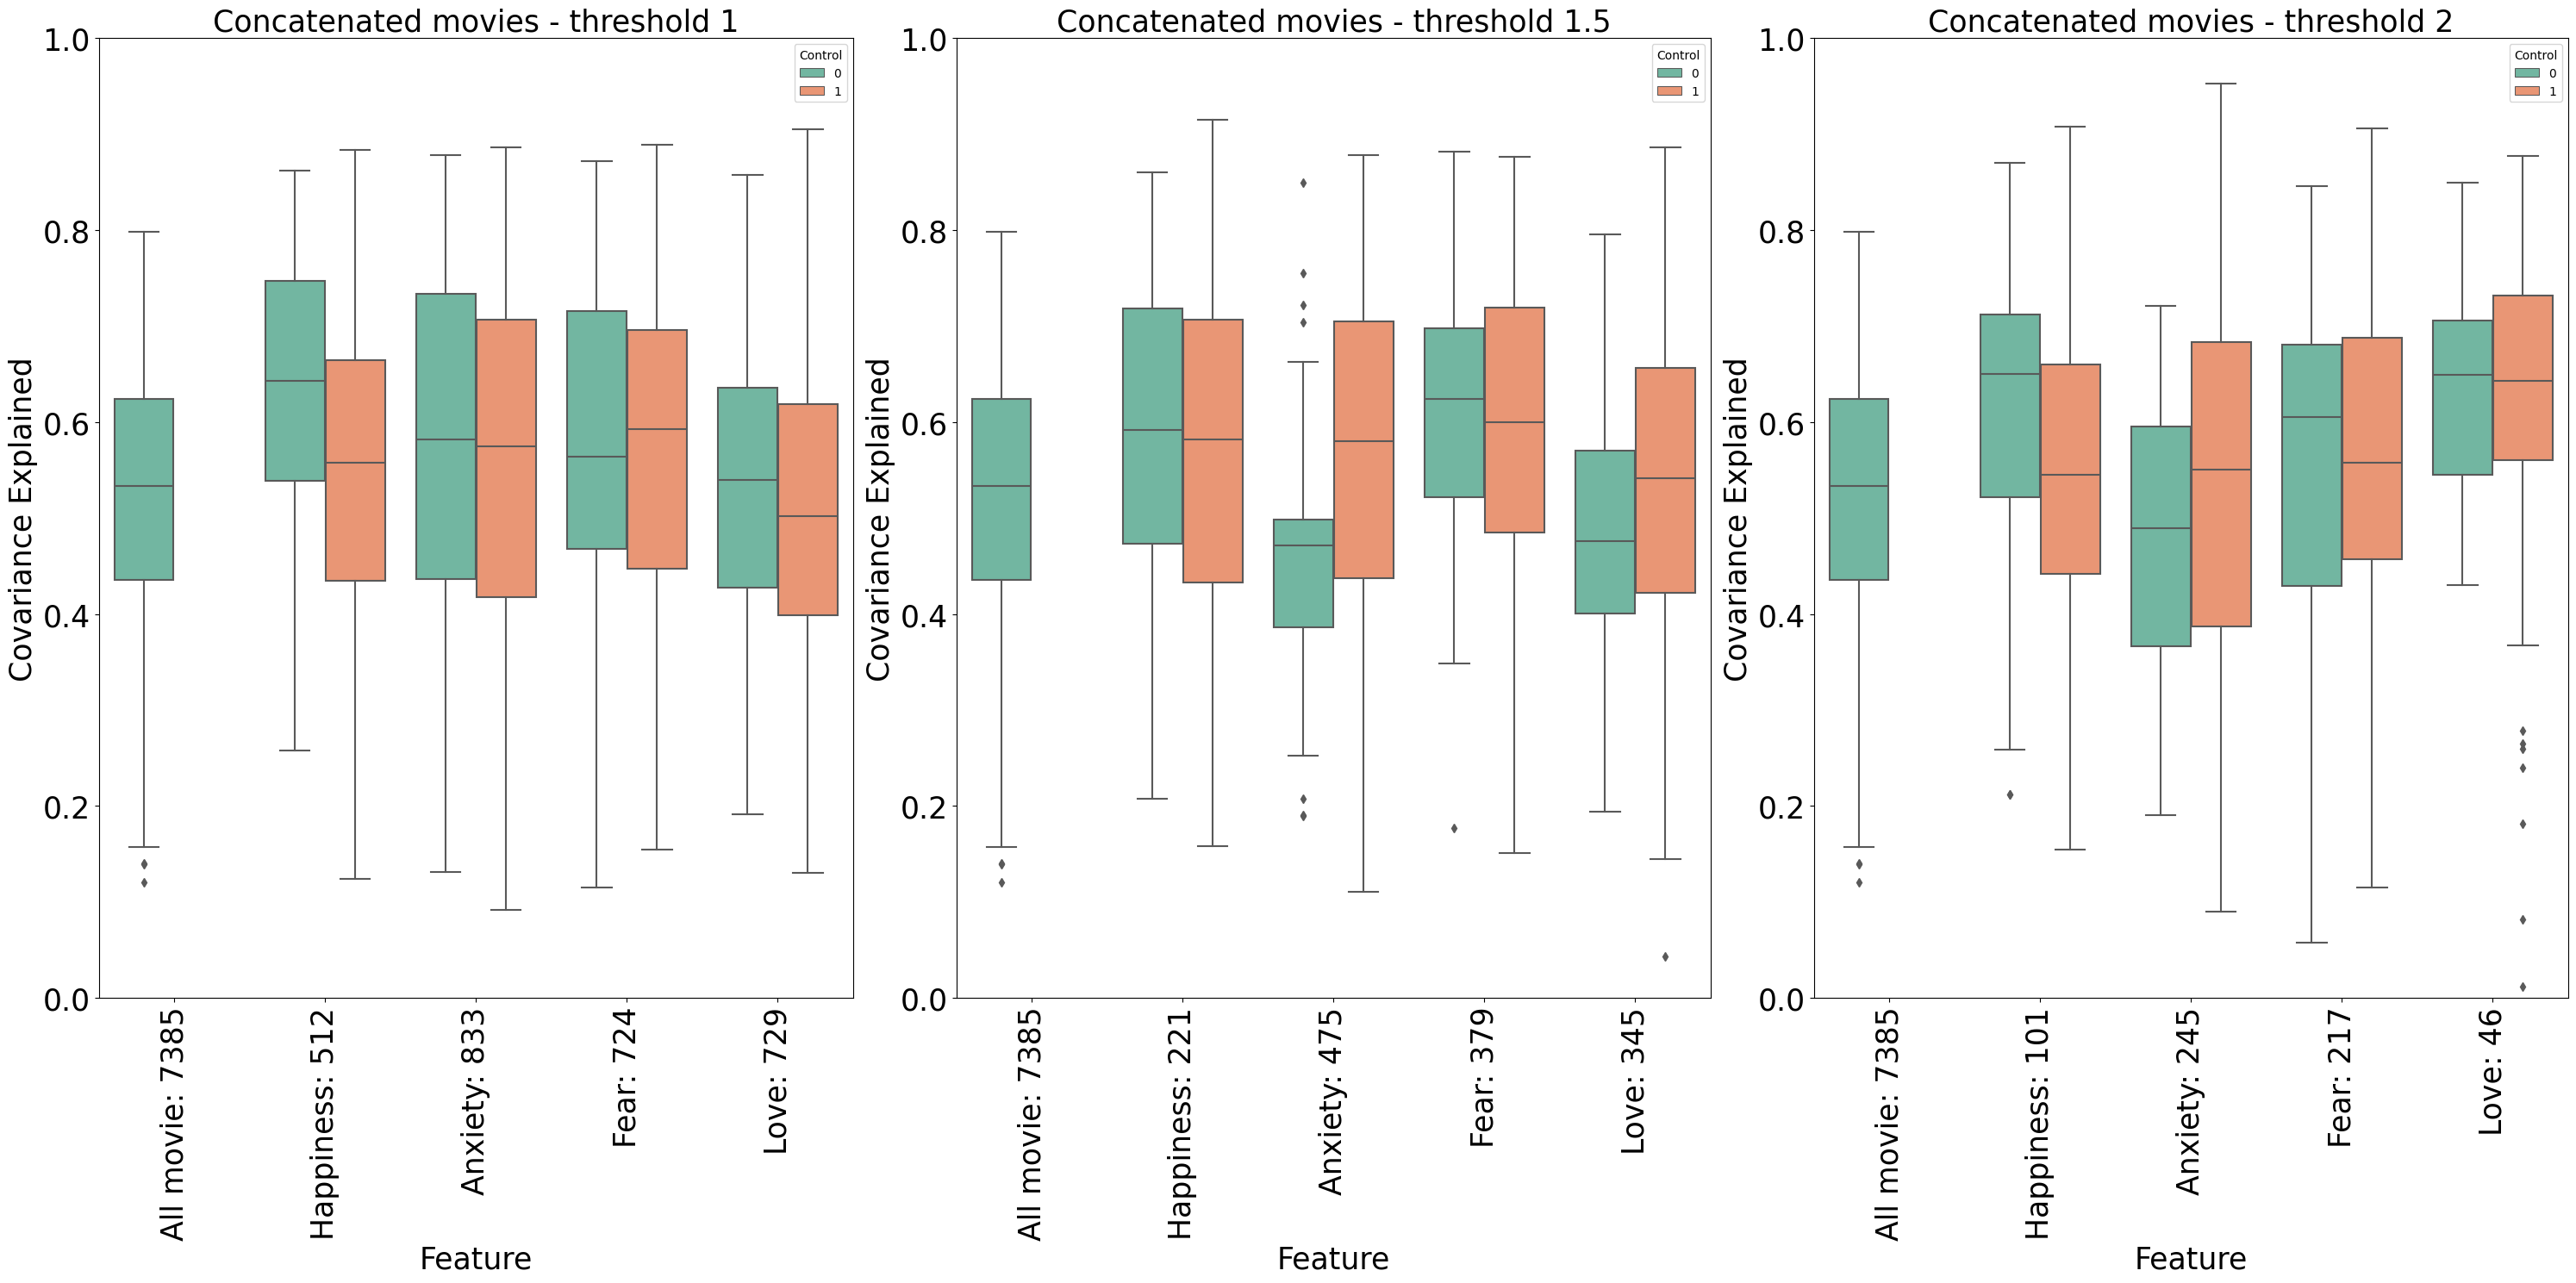

In [46]:
thresholds = [1, 1.5, 2]

significant = retrieve_significant_data(peaks_data, data_all, count_pts, thresholds, emotions)
plot_peaks(significant, emotions, thresholds)

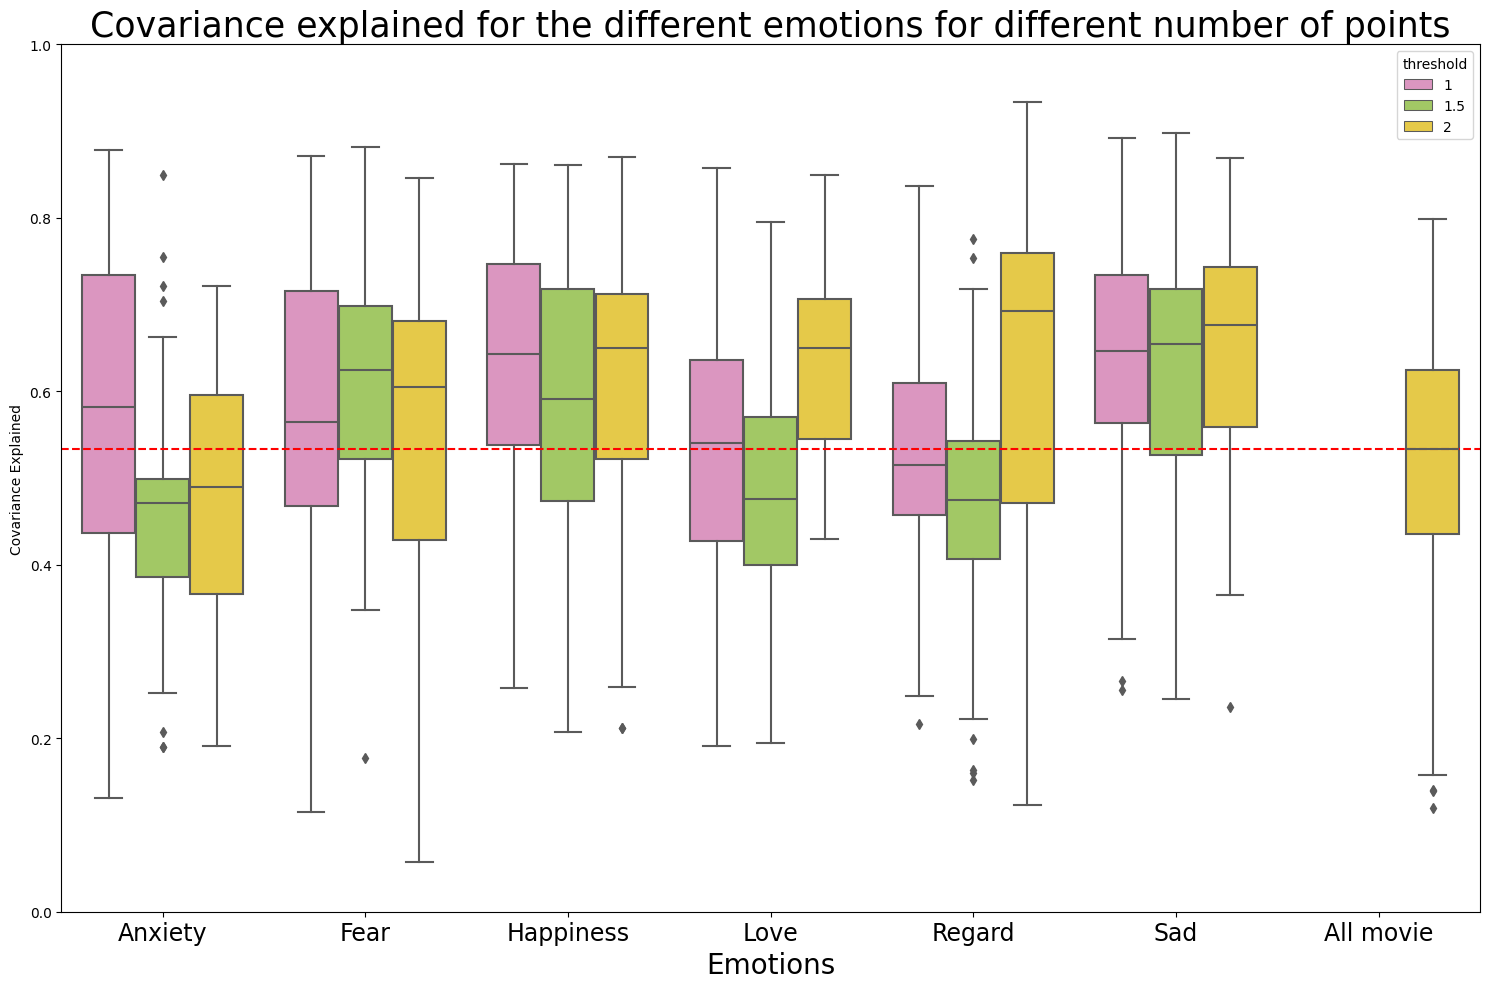

In [49]:
increase_thr(significant, emotions, order_hue = [1, 1.5, 2], on = 'threshold')

## **Mean values**

The shape of the data_concat is:  (7385, 50)


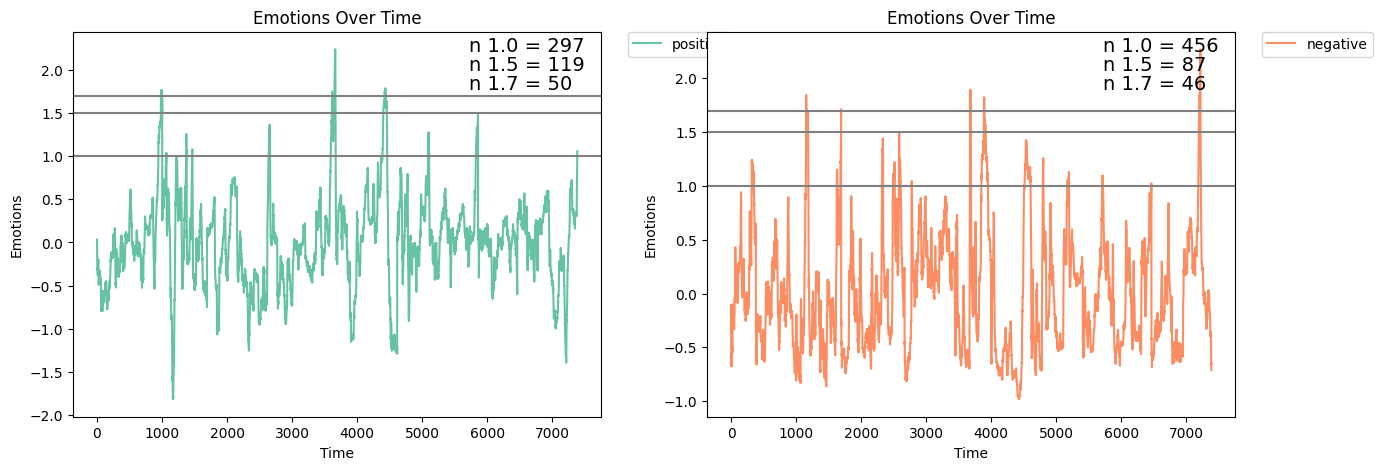

{1: {'positive': 297, 'negative': 456, 'All Movie': 7385},
 1.5: {'positive': 119, 'negative': 87, 'All Movie': 7385},
 1.7: {'positive': 50, 'negative': 46, 'All Movie': 7385}}

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def count_emotions_above_threshold(data, threshold, emotions):
    """Counts the number of points above a given threshold for specified emotions."""
    return len(data[data[emotions].mean(axis=1) > threshold])

def plot_emotions(data, threshold, count_pts):
    """Plots emotions with annotations."""
    sns.set_palette(sns.color_palette("Set2", 8))
    # create two plots, one for positive and one for negative emotions
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    for i, emotions in enumerate(['positive', 'negative']):
        ax[i].plot(data[emotions], label=emotions, color=sns.color_palette()[i])
    
        for thr in threshold:
            ax[i].axhline(y=thr, color='grey', linestyle='-')
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Emotions')
        ax[i].set_title(f'Emotions Over Time')
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax[i].annotate(f'n 1.0 = {count_pts[1][emotions]}', xy=(0.75, 0.95), xycoords='axes fraction', fontsize = 14)
        ax[i].annotate(f'n 1.5 = {count_pts[1.5][emotions]}', xy=(0.75, 0.90), xycoords='axes fraction', fontsize = 14)
        ax[i].annotate(f'n 1.7 = {count_pts[1.7][emotions]}', xy=(0.75, 0.85), xycoords='axes fraction', fontsize = 14)
    plt.show()

def counting_points(thresholds):
    """Counts the number of points above given thresholds for positive and negative emotions."""
    count_pts = {}
    positive_emotions = ['Love', 'Regard', 'WarmHeartedness', 'Pride', 'Satisfaction', 'Happiness']
    negative_emotions = ['Sad', 'Anxiety', 'Fear', 'Guilt', 'Disgust', 'Anger']

    data = concat_emo(server = False)
    data['positive'] = data[positive_emotions].mean(axis=1)
    data['negative'] = data[negative_emotions].mean(axis=1)

    for thr in thresholds:
        positive_count = count_emotions_above_threshold(data, thr, positive_emotions)
        negative_count = count_emotions_above_threshold(data, thr, negative_emotions)
        count_pts[thr] = {'positive': positive_count, 'negative': negative_count, 'All Movie': len(data)}

    return count_pts, data

# Example usage:
thresholds = [1, 1.5, 1.7]  # Example thresholds
count_pts, data = counting_points(thresholds)
plot_emotions(data, thresholds, count_pts)
count_pts

In [51]:
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSmean_concat.csv')
peaks_data.dropna(inplace=True)
peaks_data.loc[(peaks_data['threshold'] != 1.0) & (peaks_data['threshold'] != 1.5), 'threshold'] = 1.7
thresholds = peaks_data[peaks_data['Emotion'] == 'positive'].threshold.unique()

In [52]:
# Read the data for the PLS computed on all the movies concatenated
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])
data_all['Region'] = 'ALL'
data_all['Type'] = 'bold'
data_all['Emotion'] = 'All movie'
data_all.reset_index(inplace=True, drop=False)
data_all.rename(columns={'index': 'bootstrap_round'}, inplace=True)

In [53]:
# round the threshold columns to 1 decimal
peaks_data['threshold'] = peaks_data['threshold'].apply(lambda x: round(x, 1))

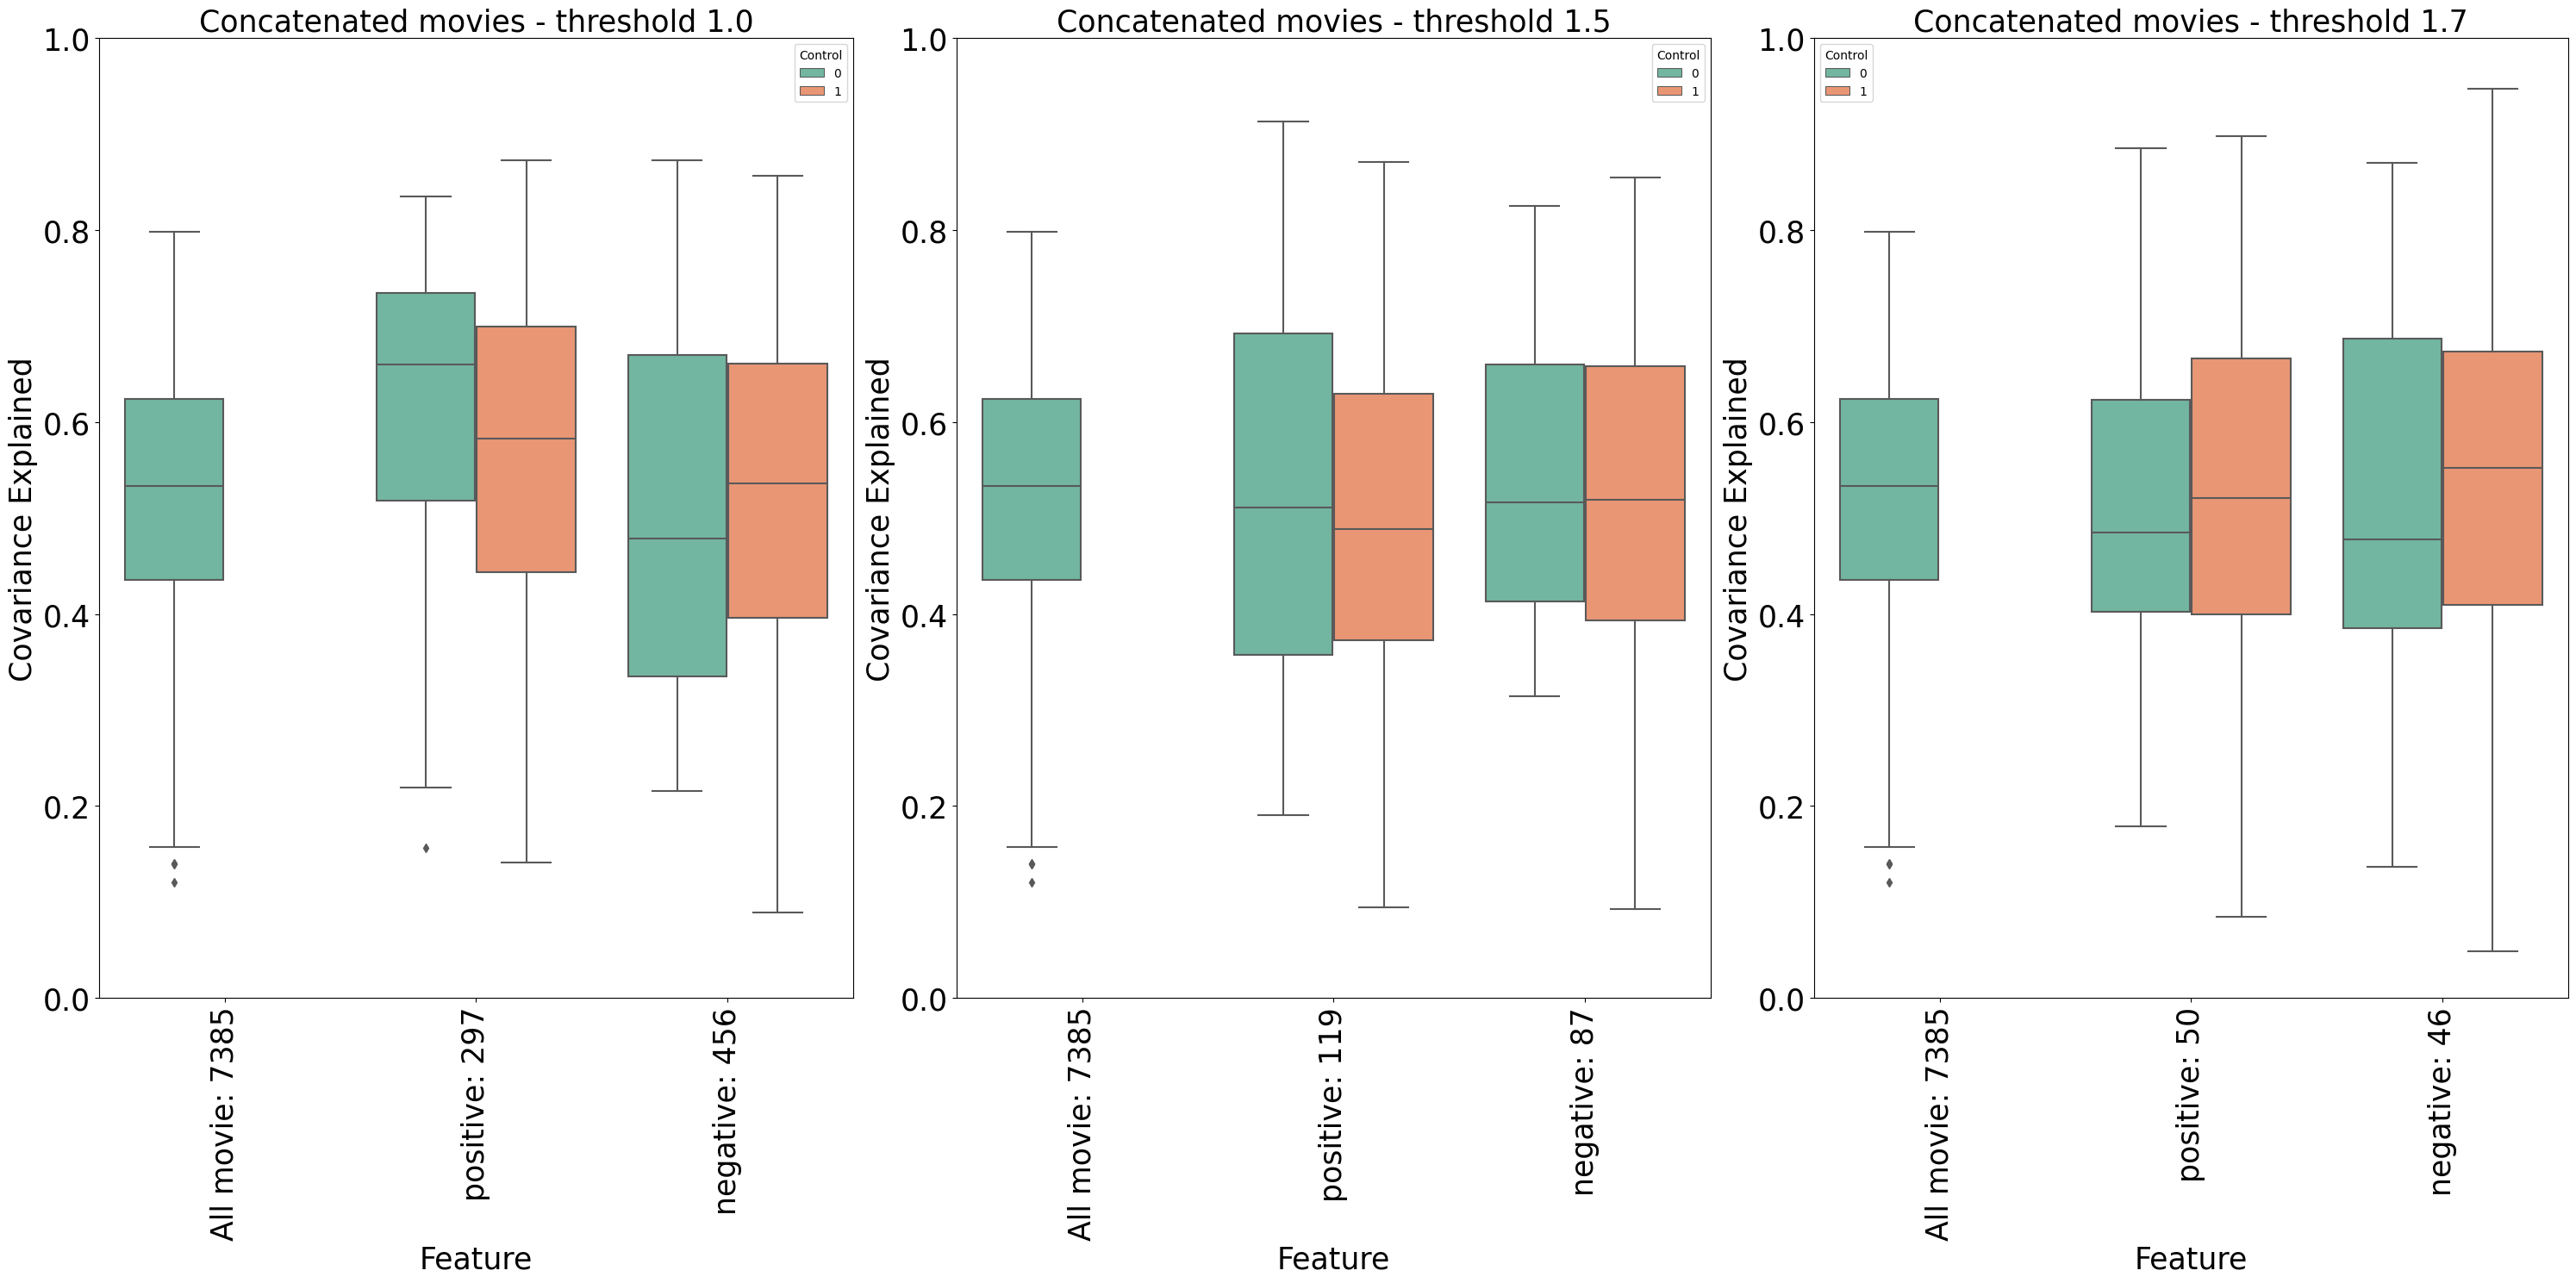

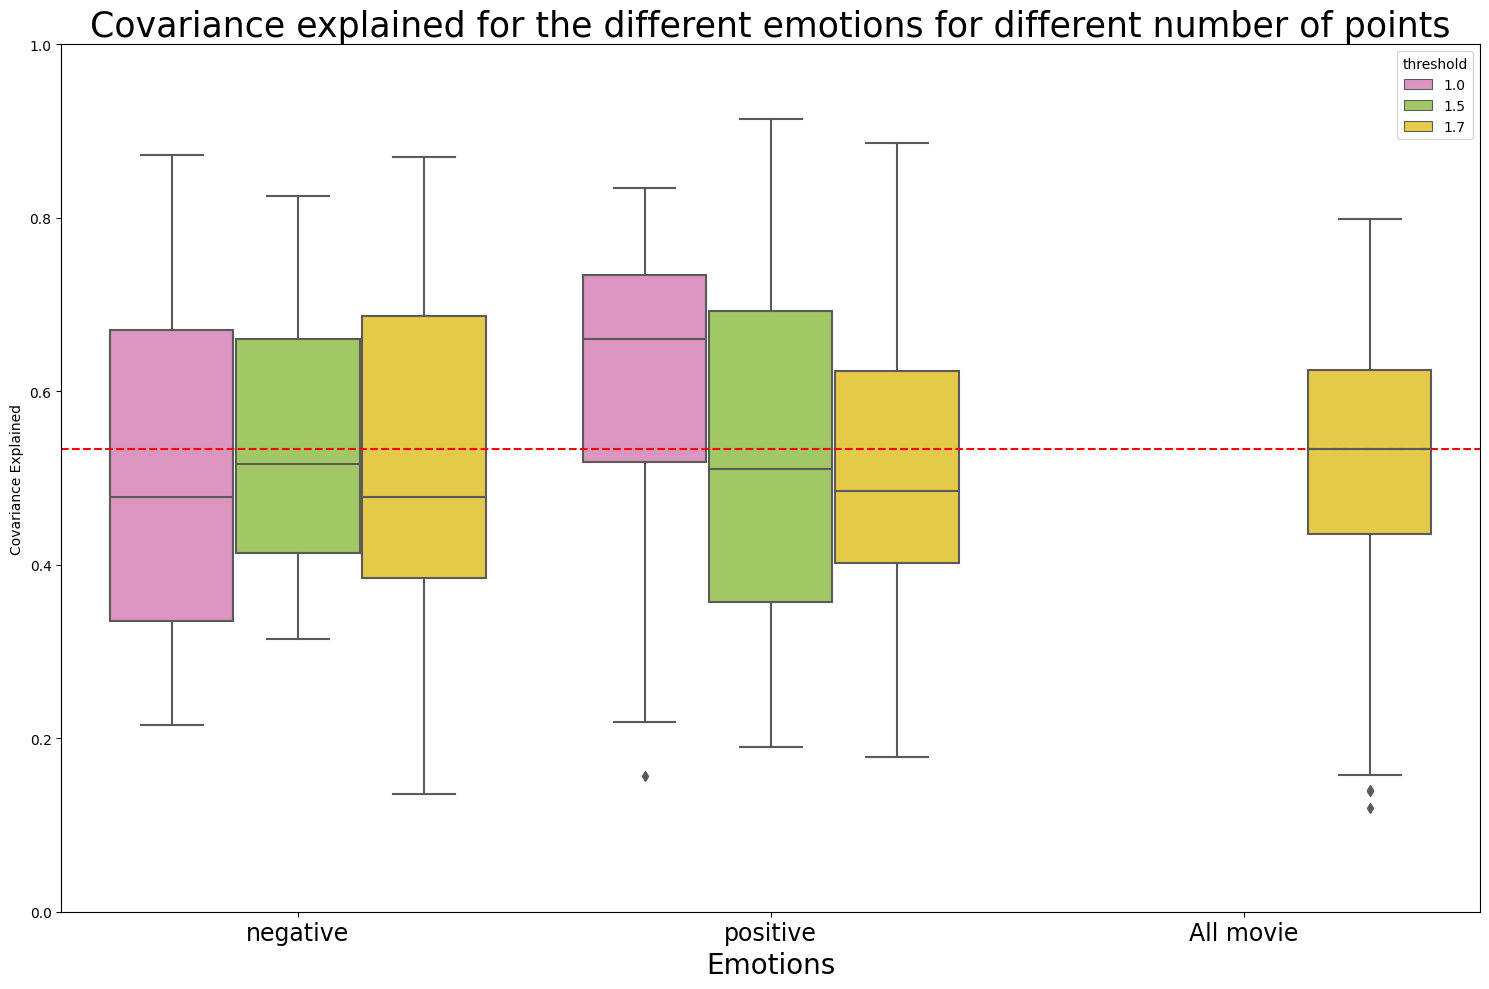

In [57]:
peaks_data.rename(columns={'Emotion': 'Feature'}, inplace=True)
data_all.rename(columns={'Emotion': 'Feature'}, inplace=True)

significant = retrieve_significant_data(peaks_data, data_all, count_pts, [1, 1.5, 1.7], ['positive', 'negative'])
significant.fillna(50, inplace=True)
plot_peaks(significant, ['positive', 'negative'], thresholds)
increase_thr(significant, ['positive', 'negative'], on = 'threshold')

## Plot for the presentation of 16/11/2023

This is the official plot 

In [ ]:
# emotions = ['Happiness']
# thresholds = [1, 1.5, 2]
# for movie in ['Sintel', 'Superhero', 'TearsOfSteel', 'TheSecretNumber']:

#     # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
#     peaks_data = all_peaks_data
#     significant = peaks_data[peaks_data['P-value'] < 0.05]
#     significant = significant.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

#     # read control
#     significant_control = all_emo_control
#     significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
#     significant_all_movie = significant_all_movie.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

#     # merge the two dataframes
#     significant = pd.concat([significant, significant_control, significant_all_movie], axis = 0)
#     significant = significant[significant['Movie'] == movie]

#     # add a control column to the dataframe if emotion ends with control
#     significant['Control'] = significant['Emotion'].apply(lambda x: 1 if x.split('_')[-1] == 'control' else 0)

#     # add the number of points to the dataframe
#     for emotion in emotions:
#         significant.loc[significant['Emotion'] == emotion.split('_')[0], 'Number of points'] = count_pts[movie][thr][emotion]
#     significant.loc[significant['Emotion'] == 'All movie', 'Number of points'] = count_pts[movie][thr]['All movie']

#     # EMOTION PEAKS
#     labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
#     data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
#     data.columns = labels['Columns']
#     emotions = peaks_data.emotion.unique()

#     # PLOT
#     palette = sns.color_palette("Set2", 8)
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
#     box = ax1.get_position()
#     ax1.set_position([box.x0, box.y0, box.width * 1.25, box.height])
#     box = ax2.get_position()
#     ax2.set_position([box.x0 + 0.1, box.y0, box.width * 1, box.height])
#     ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#     ax2.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

#     palette_sns = {
#         'Anxiety': sns.color_palette("Set2", 8)[3],
#         'Anxiety_control': sns.color_palette("Set2", 8)[-1],
#         'Sad': sns.color_palette("Set2", 8)[2],
#         'Sad_control': sns.color_palette("Set2", 8)[-1],
#         'Happiness': sns.color_palette("Set2", 8)[1],
#         'Happiness_control': sns.color_palette("Set2", 8)[-1],
#         'Love': sns.color_palette("Set2", 8)[0],
#         'Love_control': sns.color_palette("Set2", 8)[-1],
#         'All movie': sns.color_palette("Set2", 8)[5],
#     }
#     # plot the boxplot
#     order_emotions = ['All Movie']
#     for emotion in ['Happiness']:
#         order_emotions.append(emotion)
#         order_emotions.append(emotion + '_control')

#     sns.boxplot(x = 'Emotion', y = 'Covariance Explained', order = order_emotions, data = significant, ax = ax1, palette = palette_sns)
#     list_n = []
#     for emo in order_emotions:
#         n = significant[significant['Emotion'] == emo.split('_')[0]]['Number of points'].unique()
#         if len(n) == 0:
#             n = 0
#         else:
#             n = n[0]
#         list_n.append(f'{emo}: {int(n)}')

#     ax1.set_xticklabels(list_n, rotation=45, ha='right')
#     # give colors to the x labels
#     for i, emotion in enumerate(list_n):
#         if emotion.split(':')[0] in emotions:
#             ax1.get_xticklabels()[i].set_color(palette[list(emotions).index(emotion.split(':')[0])])
#         else:
#             ax1.get_xticklabels()[i].set_color('black')
#     ax1.set_title(f'Emotion Peaks in {movie}')
#     ax1.set_xlabel('Regions')
#     ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

#     list_emot = ['Happiness', 'All Movie']
#     for emotion in list_emot:
#         ax1.annotate(f'n = {int(n)}', xy=(list(list_emot).index(emotion), -0.25), xytext=(list(list_emot).index(emotion), 0.05), fontsize = 12)

#     # plot the lineplot
#     for i, emotion in enumerate(list_emot[0:-1]):
#         print(emotion)

#         n = significant[significant['Emotion'] == emotion]['Number of points'].unique()
#         if len(n) == 0:
#             n = 0
#         else:
#             n = n[0]
#         plt.plot(data[emotion], label = emotion + f': {n}', color = palette[list(emotions).index(emotion)])

#     ax2.set_title(f'Emotion Peaks in {movie}')
#     ax2.set_xlabel('Time')
#     ax2.set_ylabel('Emotions')
#     ax2.axhline(y=1, color='grey', linestyle='-')
#     ax2.legend()
    

#     plt.show()

# **Peaks from features extracted**

In [58]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers_PLS import *

In [59]:
# Read the data of the PLS calculated on the peaks of the emotions  for the concatenated movies
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_features_extracted_concat.csv')
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])

peaks_data, data_all, features, thresholds = preprocess_peaks_concat(peaks_data, data_all)

{1.5: {'spectralflux': 564, 'rms': 553, 'zcrs': 516, 'average_brightness': 566, 'average_saturation': 554, 'average_hue': 674, 'All Movie': 7385}, 2: {'spectralflux': 222, 'rms': 336, 'zcrs': 293, 'average_brightness': 226, 'average_saturation': 290, 'average_hue': 271, 'All Movie': 7385}, 2.5: {'spectralflux': 76, 'rms': 241, 'zcrs': 172, 'average_brightness': 87, 'average_saturation': 159, 'average_hue': 69, 'All Movie': 7385}}


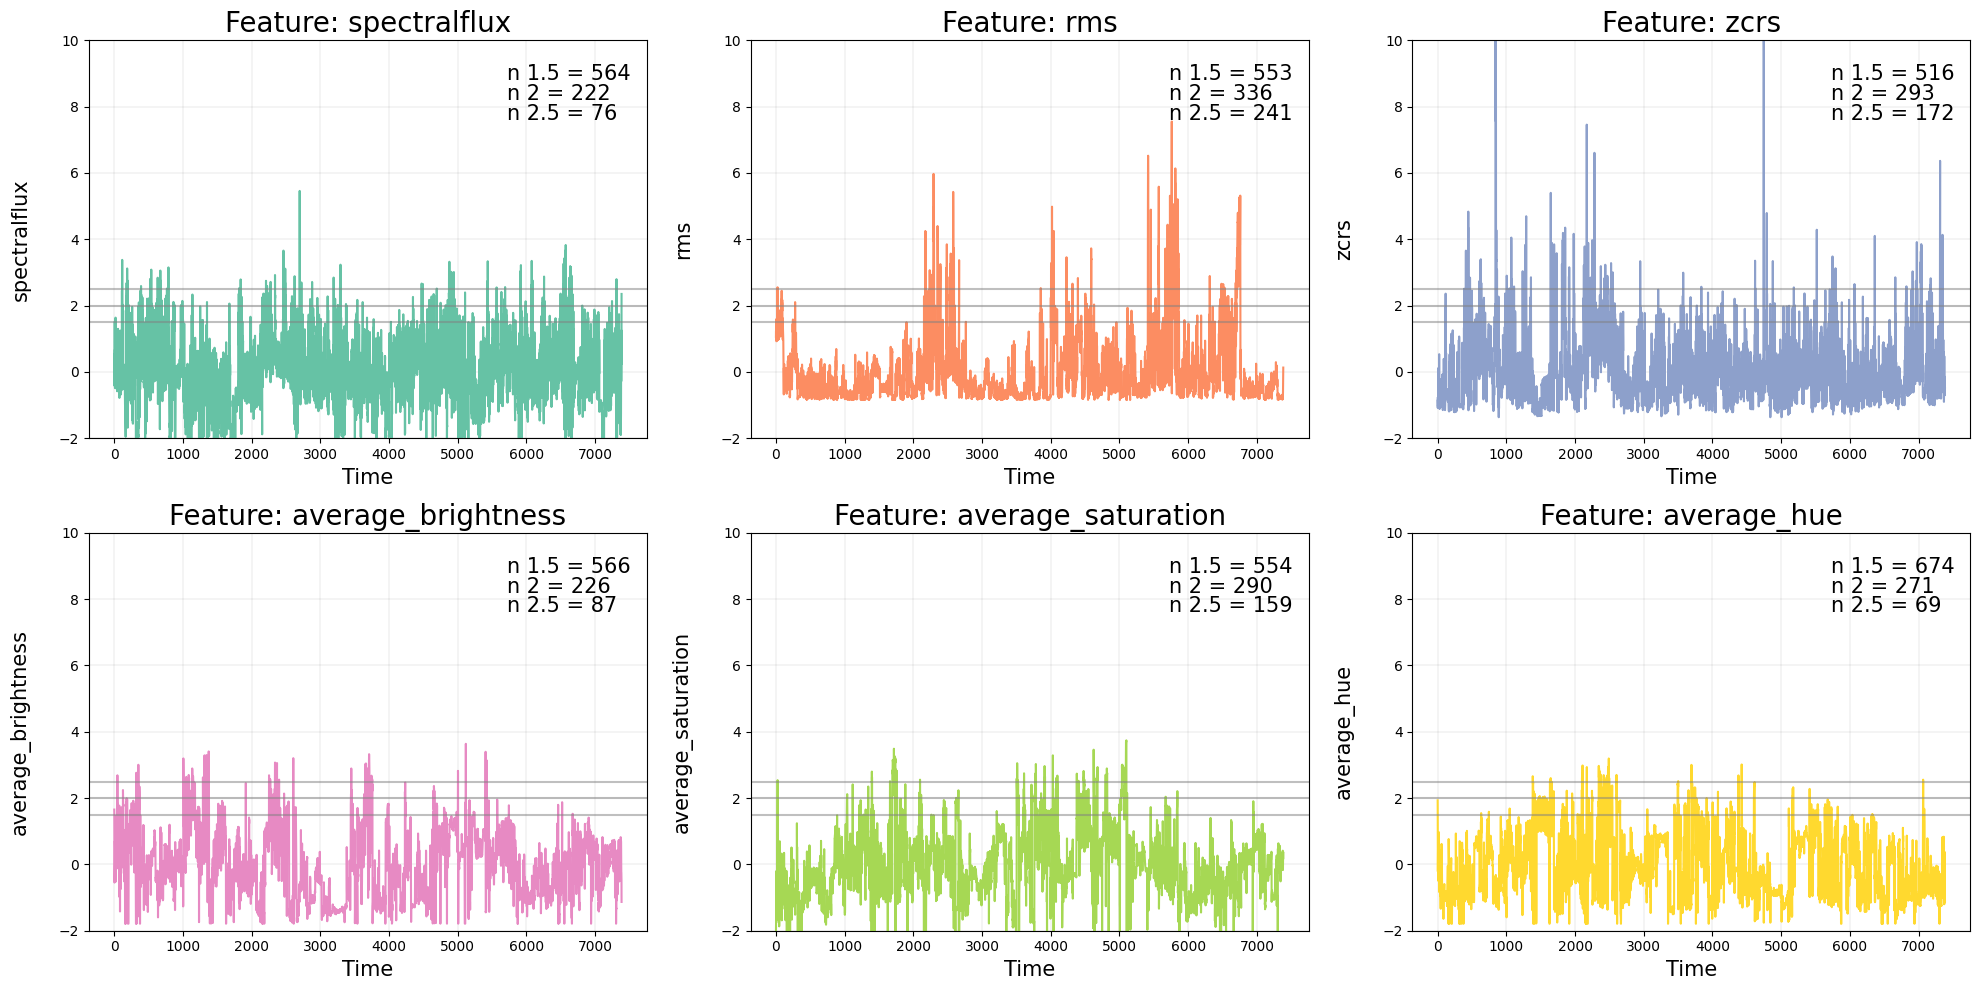

In [60]:
concatenated_features = extract_features_concat(cluster = False)

features = concatenated_features.columns
count_pts = count_features_above_threshold(concatenated_features, [1.5, 2, 2.5], features)
print(count_pts)

# plot the features
def plot_features(features, thresholds):
    num_features = features.shape[1]
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # Adjusted for 2x3 grid
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    # Predefined colors
    colors = sns.color_palette("Set2", num_features)
    
    for i, feature in enumerate(features.columns):
        ax = axes[i]
        ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        ax.set_title(f'Feature: {feature}', fontsize=20)
        ax.set_xlabel('Time', fontsize=15)
        ax.set_ylabel(feature, rotation=90, labelpad=20, fontsize=15)
        ax.plot(features[feature], color=colors[i])  # Use different color for each line
        ax.set_ylim([-2, 10])

        # Add the threshold lines
        for thr in thresholds:
            ax.axhline(y=thr, color='grey', linestyle='-', alpha=0.5)

        # add a text with the number of points above the threshold
        ax.annotate(f'n {1.5} = {count_pts[1.5][feature]}', xy=(0.75, 0.90), xycoords='axes fraction', fontsize = 15)
        ax.annotate(f'n {2} = {count_pts[2][feature]}', xy=(0.75, 0.85), xycoords='axes fraction', fontsize = 15)
        ax.annotate(f'n {2.5} = {count_pts[2.5][feature]}', xy=(0.75, 0.80), xycoords='axes fraction', fontsize = 15)

    plt.tight_layout()
    plt.show()

plot_features(concatenated_features, [1.5, 2, 2.5])

average_brightness 566
average_brightness 226
average_brightness 87
average_saturation 554
average_saturation 290
average_saturation 159
average_hue 674
average_hue 271
average_hue 69


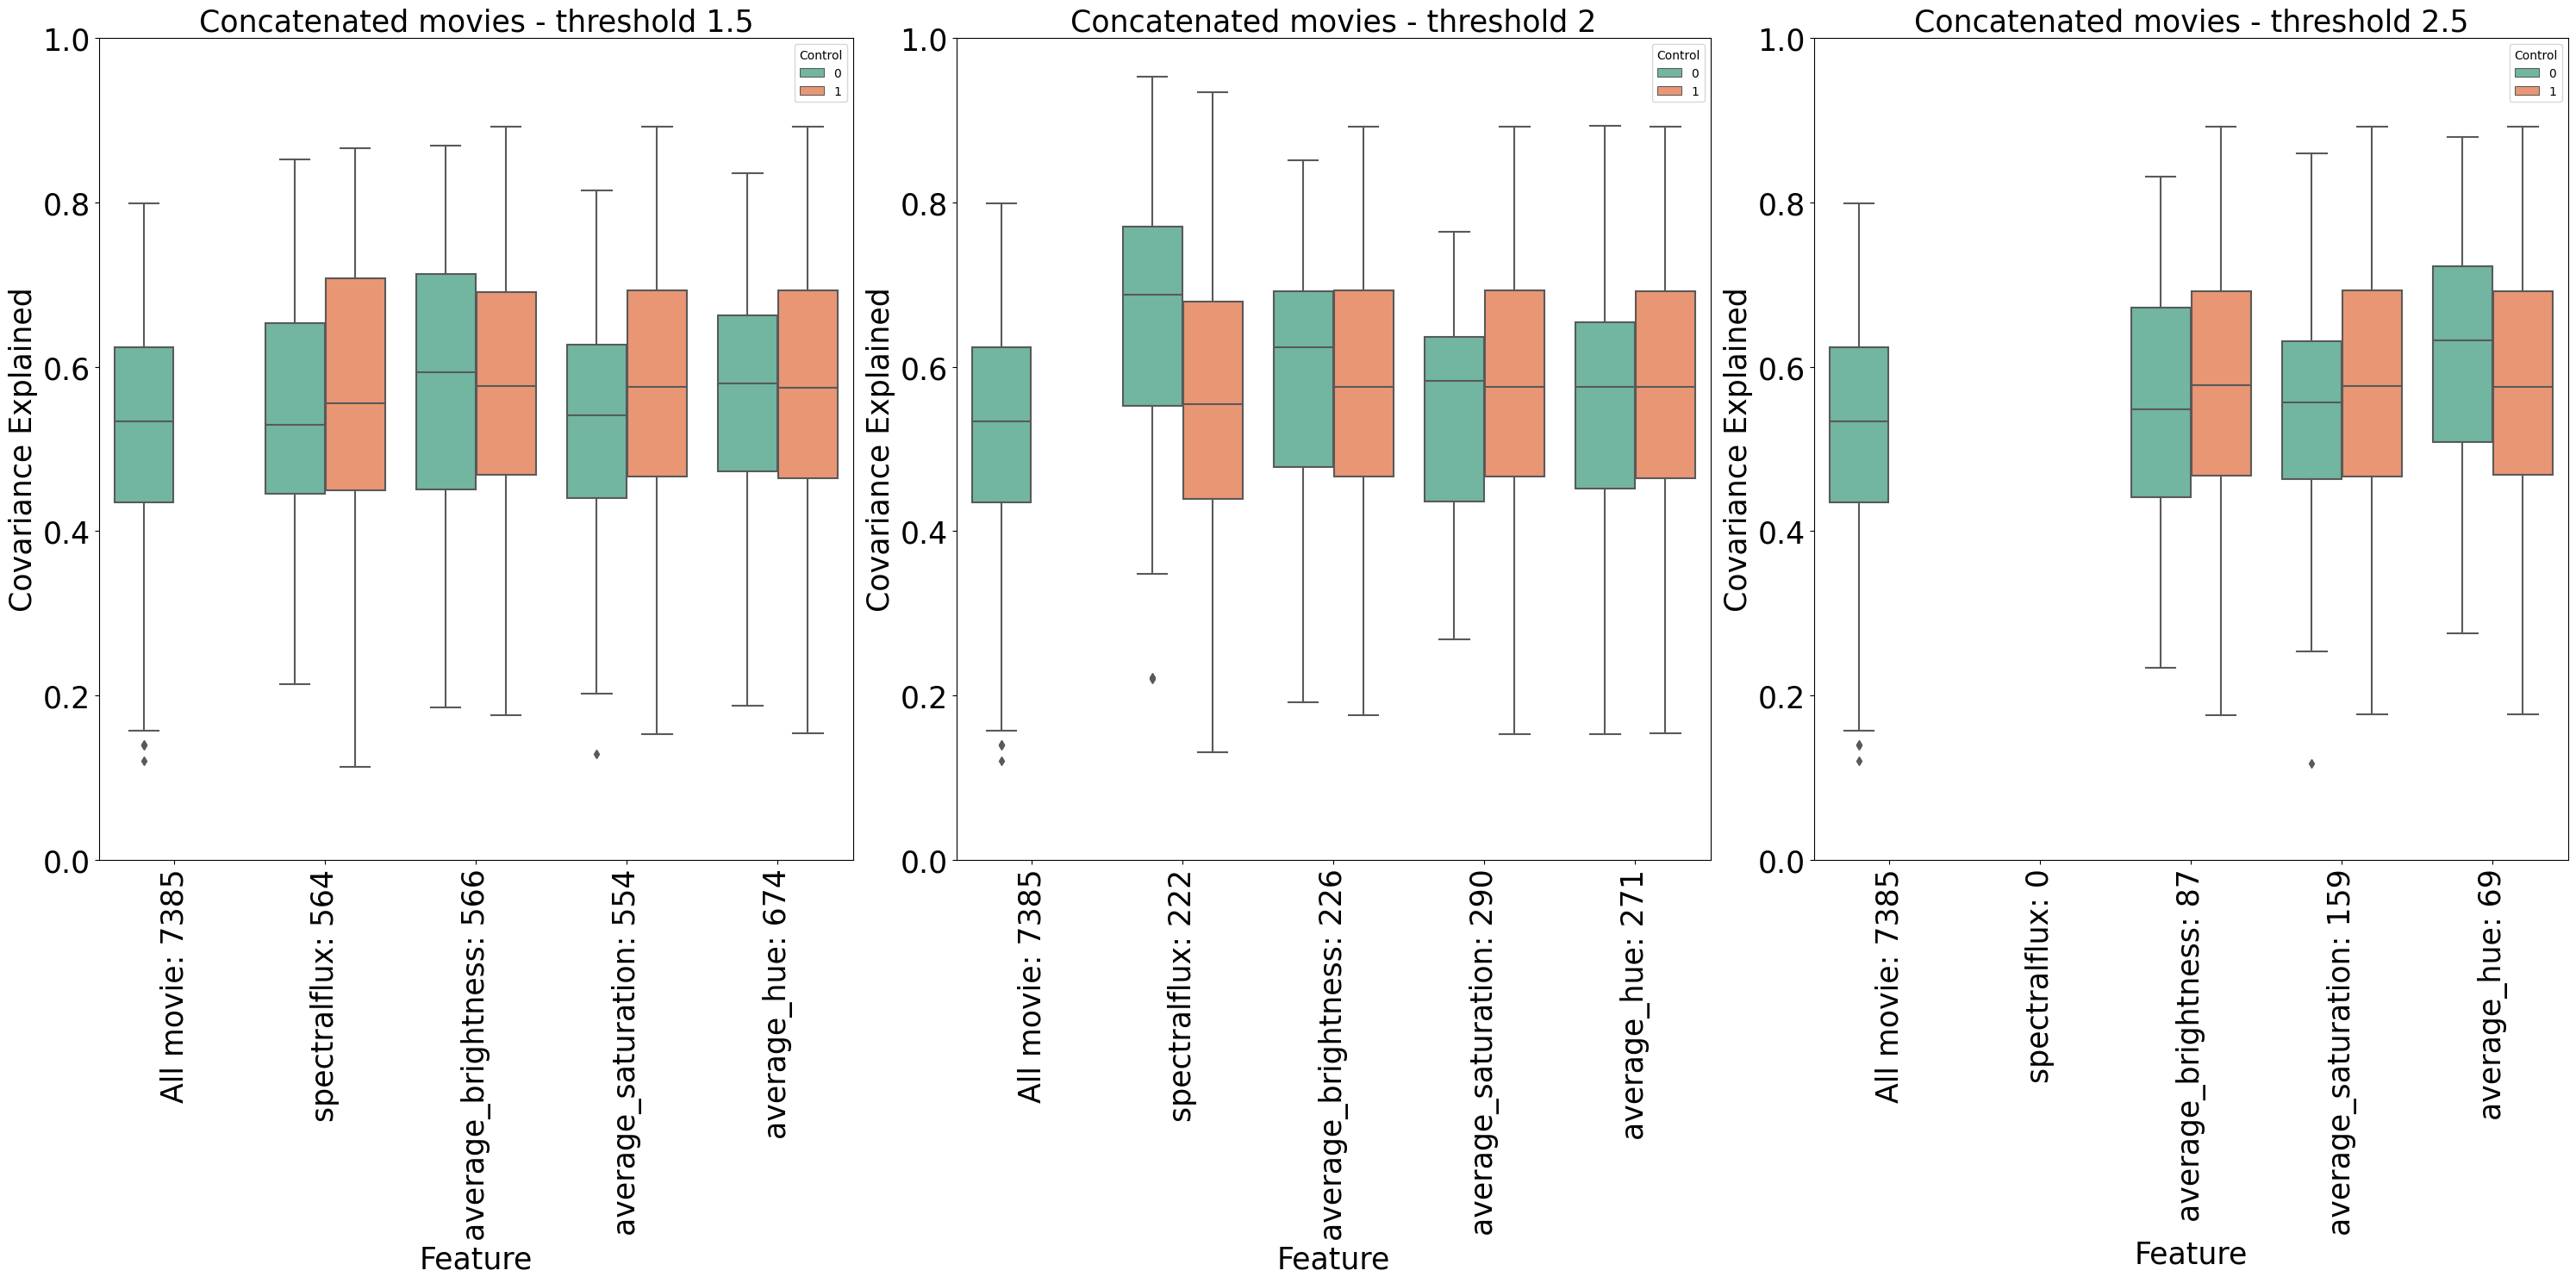

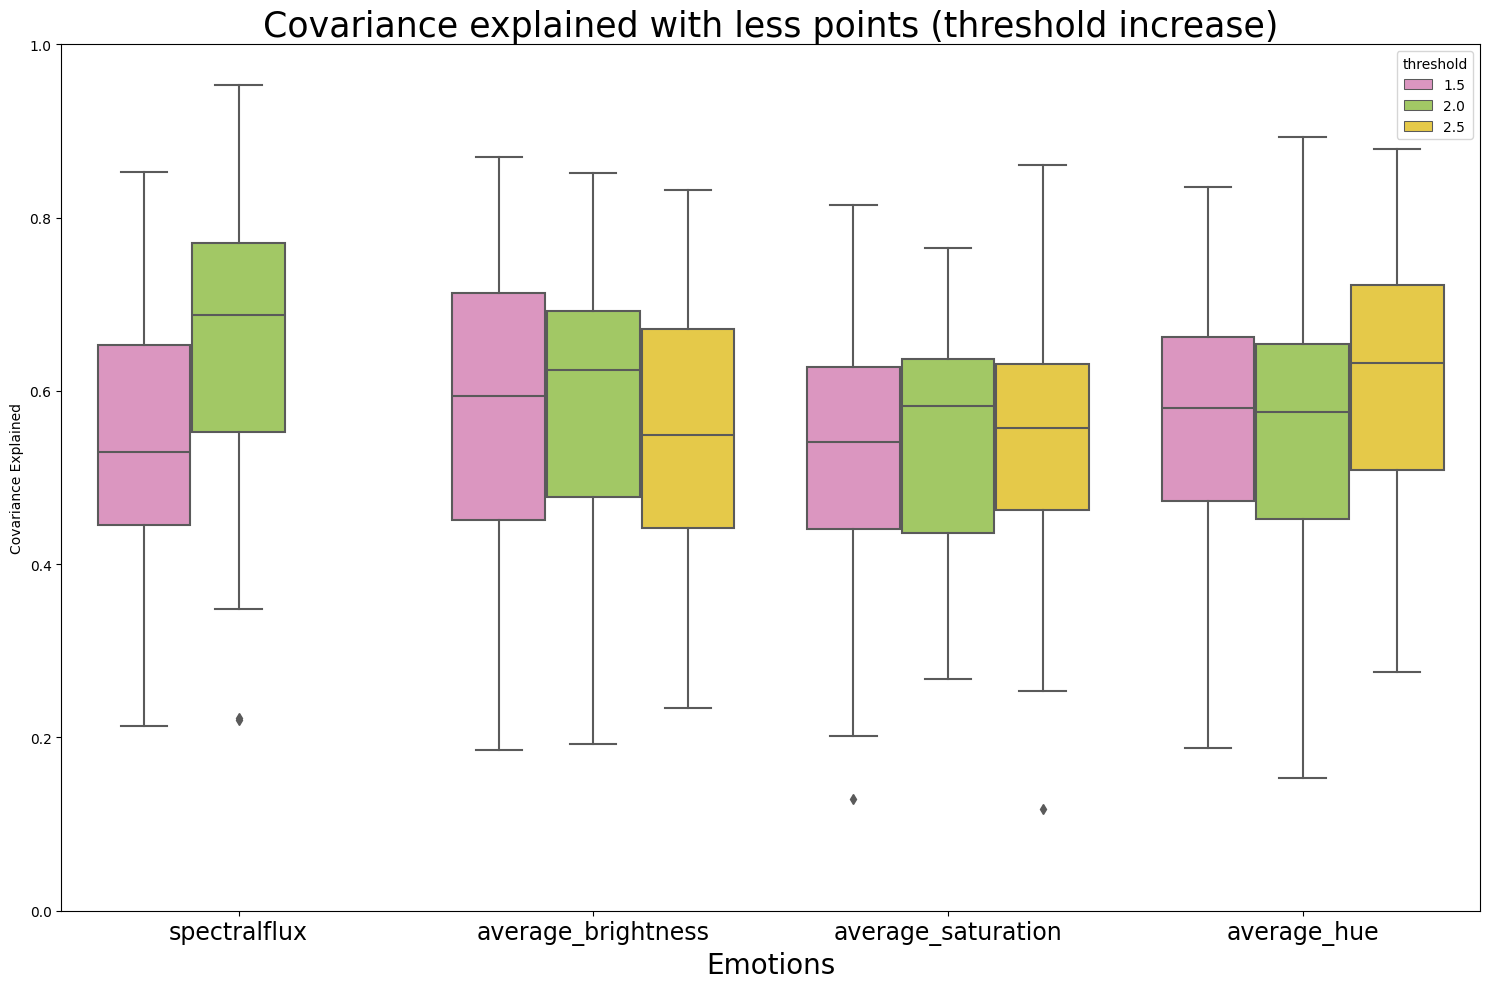

In [64]:
thresholds = [1.5, 2, 2.5]

significant = retrieve_significant_data(peaks_data, data_all, count_pts, thresholds, features)
plot_peaks(significant, ['spectralflux', 'average_brightness', 'average_saturation', 'average_hue'], thresholds)
features = ['spectralflux', 'average_brightness','average_saturation', 'average_hue']
increase_thr(significant, features, on='threshold')

# **Peaks from concat movie points**

In [21]:
# Create the peaks data
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_concat_bold_ALL_pts.csv', delimiter=';')
peaks_data['Method'] = 'bold'
peaks_data = peaks_data.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'LC', 'Method', 'Movie']).last().reset_index()

# Create the entire movie
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])
data_all.reset_index(inplace=True, drop=False)
data_all['bootstrap_round'] = data_all.index // 12
data_all = data_all.groupby(['bootstrap_round']).last().reset_index()
data_all['threshold'] = 1
data_all['Method'] = 'bold'
data_all['Region'] = 'ALL'
data_all['Feature'] = 'All movie'
data_all['Movie'] = 'concatenated'

  Region  bootstrap_round  Feature  Number of points  threshold  \
0    ALL                0  Anxiety                50       2.58   
1    ALL                0  Anxiety               100       2.39   
2    ALL                0  Anxiety               150       2.18   
3    ALL                0  Anxiety                50       2.58   
4    ALL                0  Anxiety               100       2.39   

   Covariance Explained  Control  
0              0.640189        0  
1              0.117962        0  
2              0.107697        0  
3              0.727003        1  
4              0.627032        1  


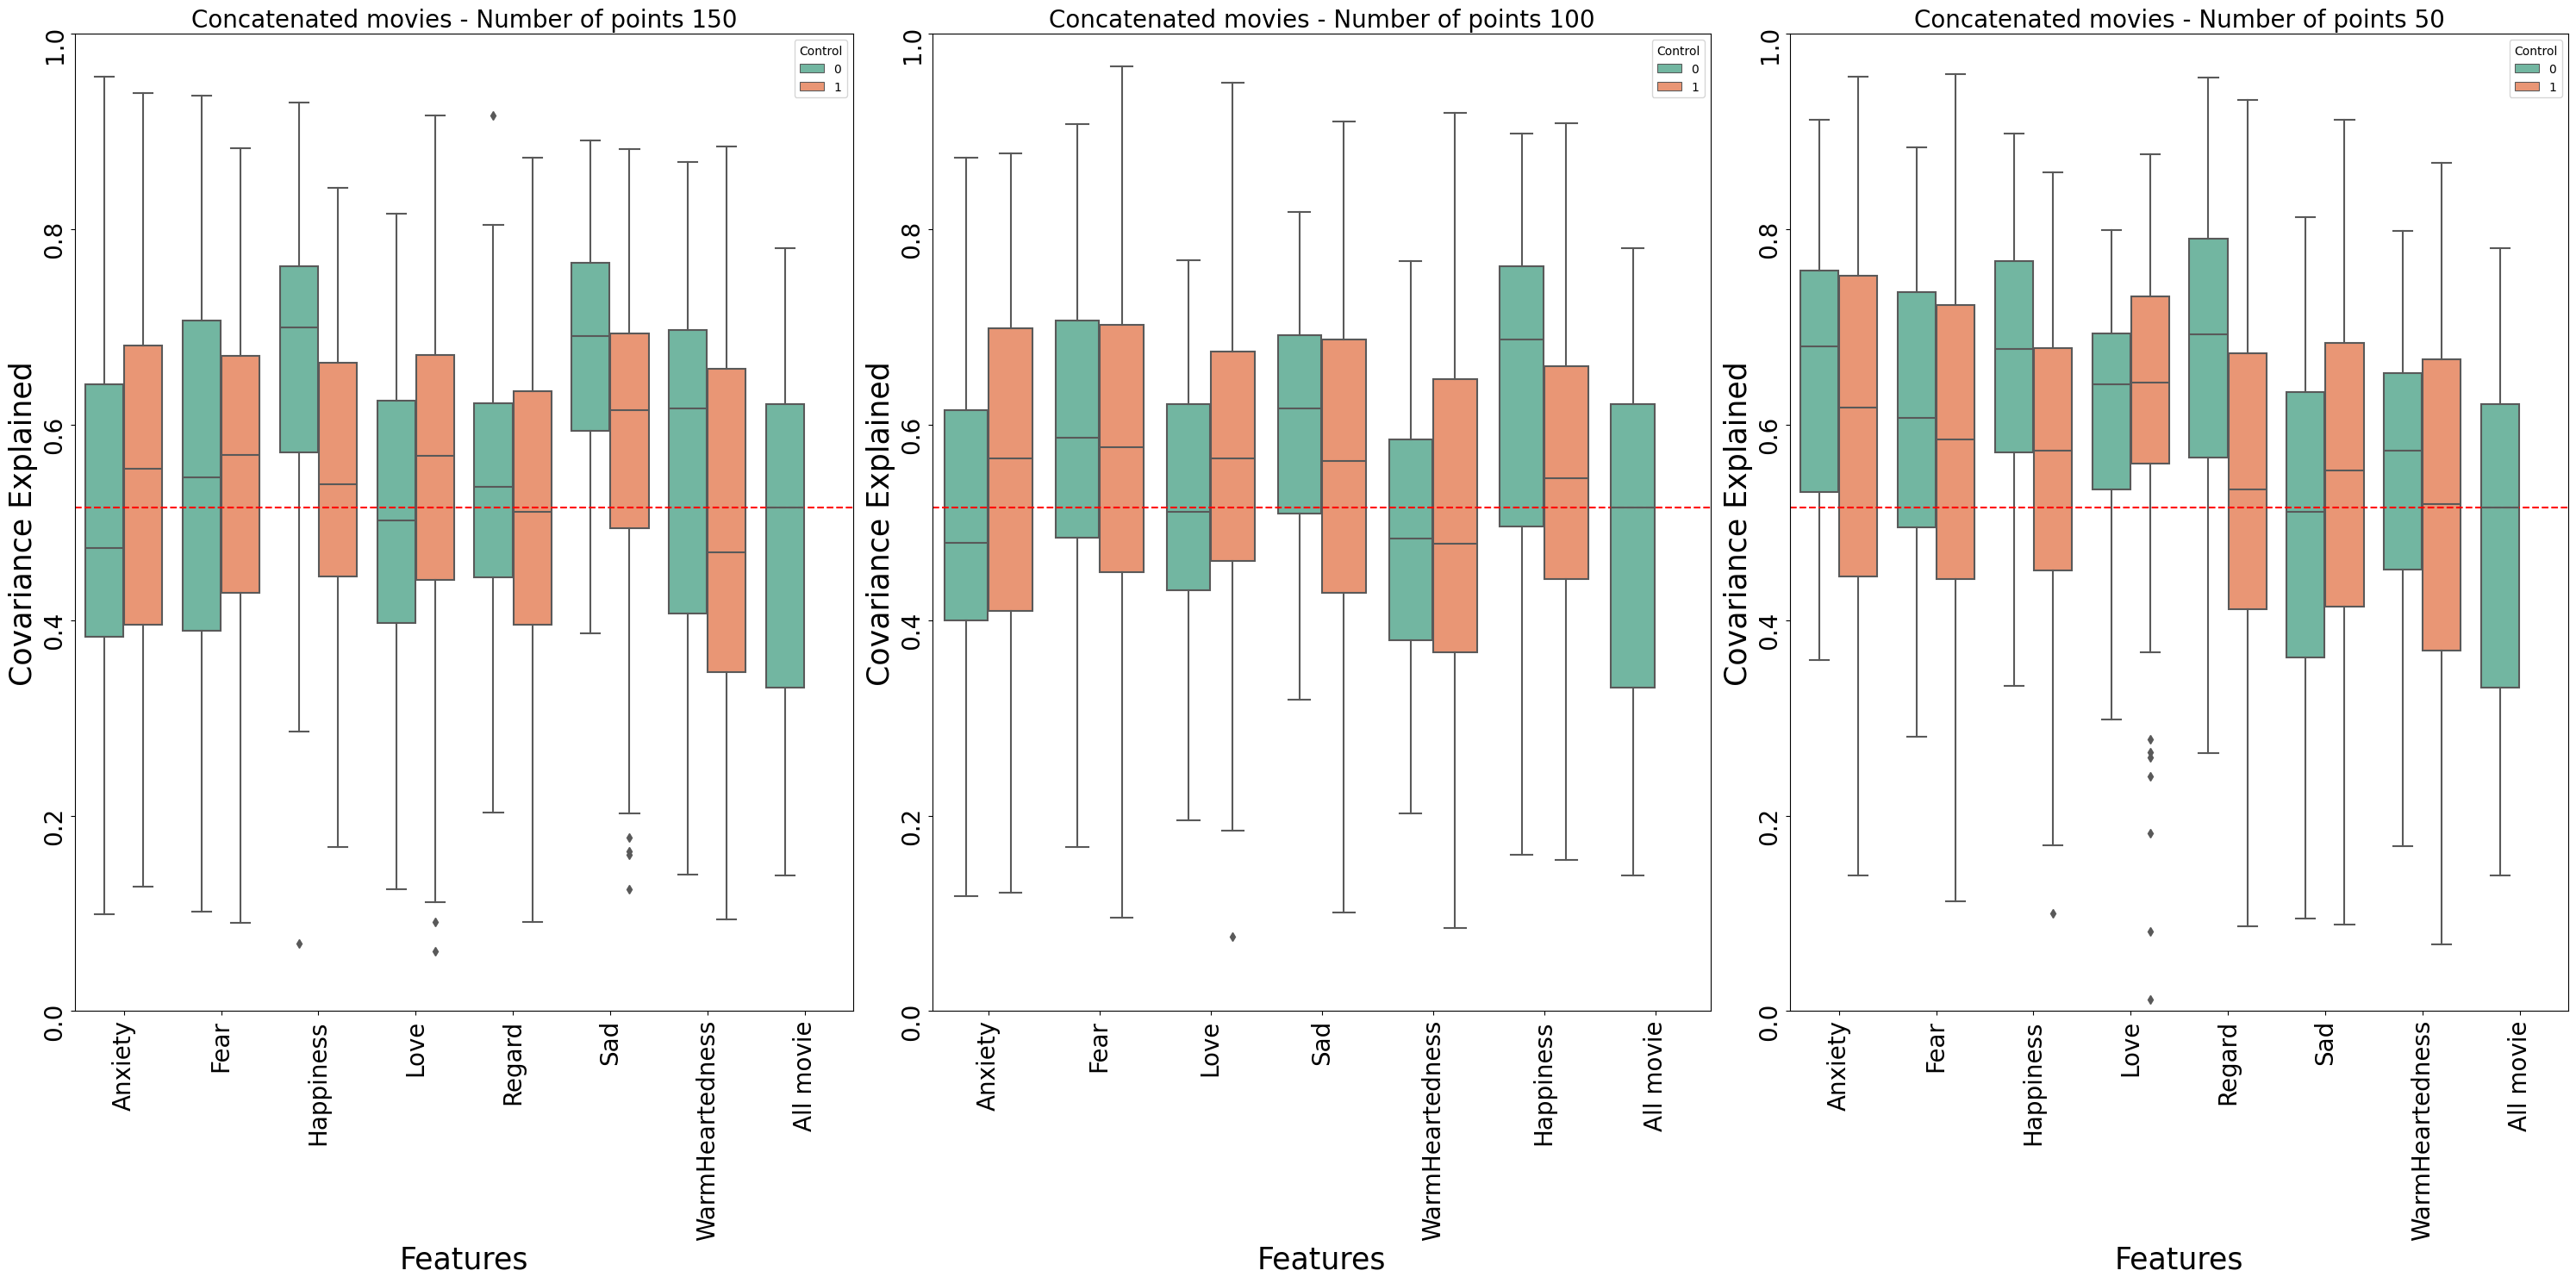

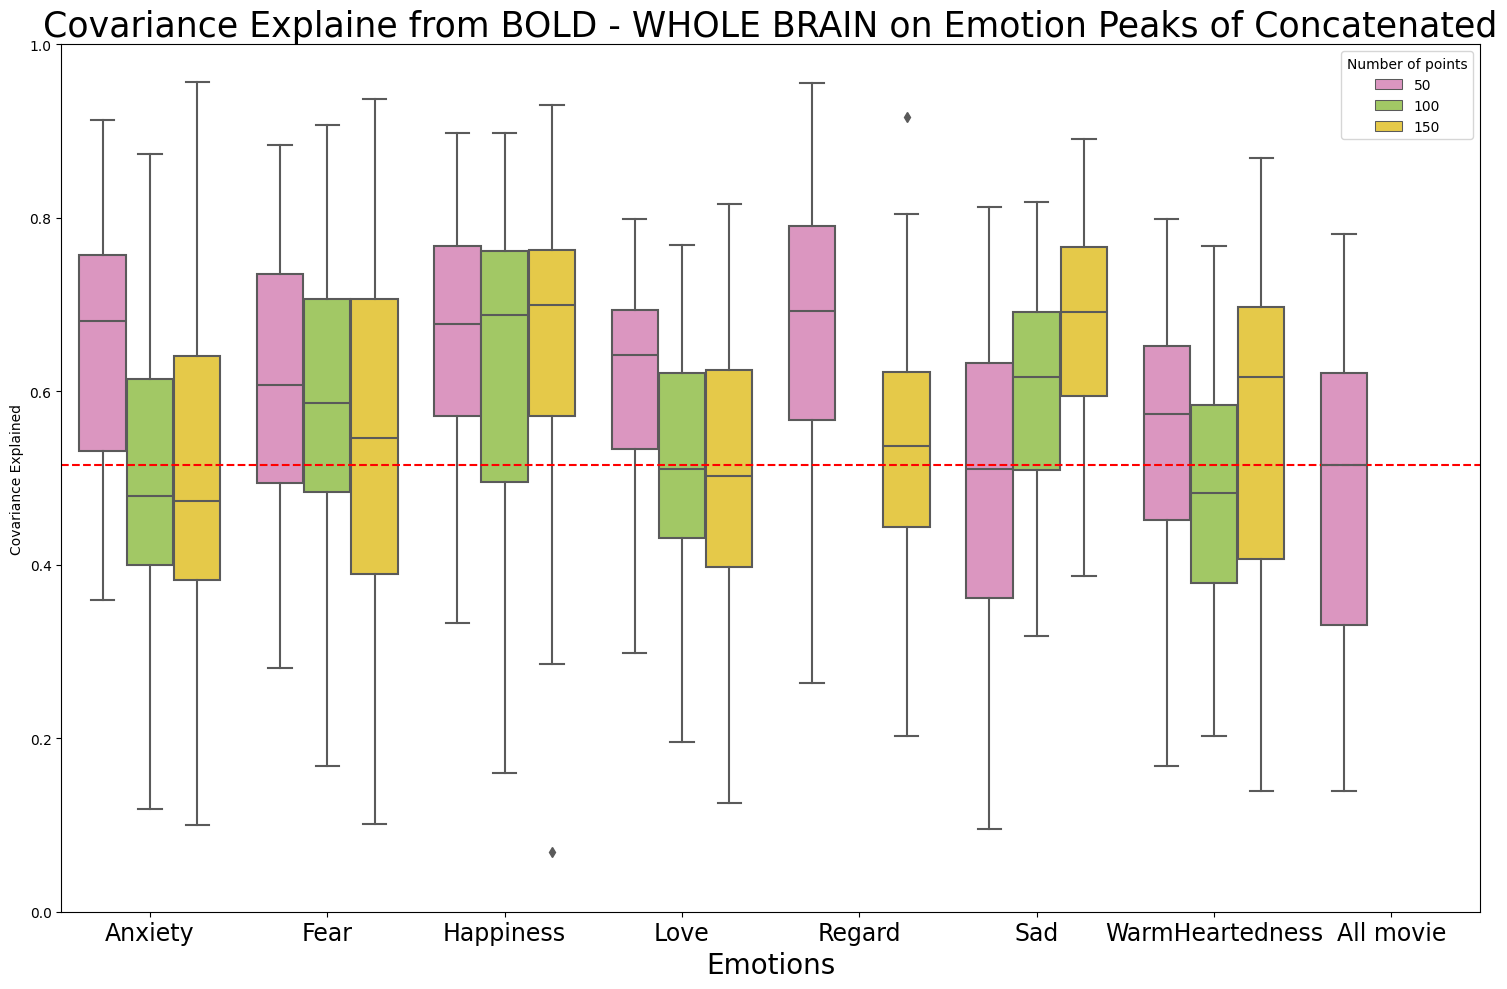

In [22]:
n_points = [50, 100, 150]

significant = retrieve_significant(peaks_data, data_all)
plot_peaks(significant, [150, 100, 50], on = 'Number of points')
increase_thr(significant, [150, 100, 50], title = f'Covariance Explaine from BOLD - WHOLE BRAIN on Emotion Peaks of Concatenated')

# **Single movie: emotions**

In [6]:
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_concat_pts.csv')

features = [x for x in peaks_data.Feature.unique() if not x.startswith('Control')]
thresholds_1 = {}
for feature in features:
    thresholds_1[feature] = peaks_data[peaks_data['Feature'] == feature]['threshold'].unique()

In [8]:
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_single_pts.csv')
peaks_data['Method'] = 'bold'
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])

peaks_data, data_all, features, thresholds = preprocess_peaks_concat(peaks_data, data_all)
peaks_data = peaks_data.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'LC', 'Method', 'Movie']).first().reset_index()

MOVIE = 'Spaceman'
peaks_data = peaks_data[peaks_data['Movie'] == MOVIE]

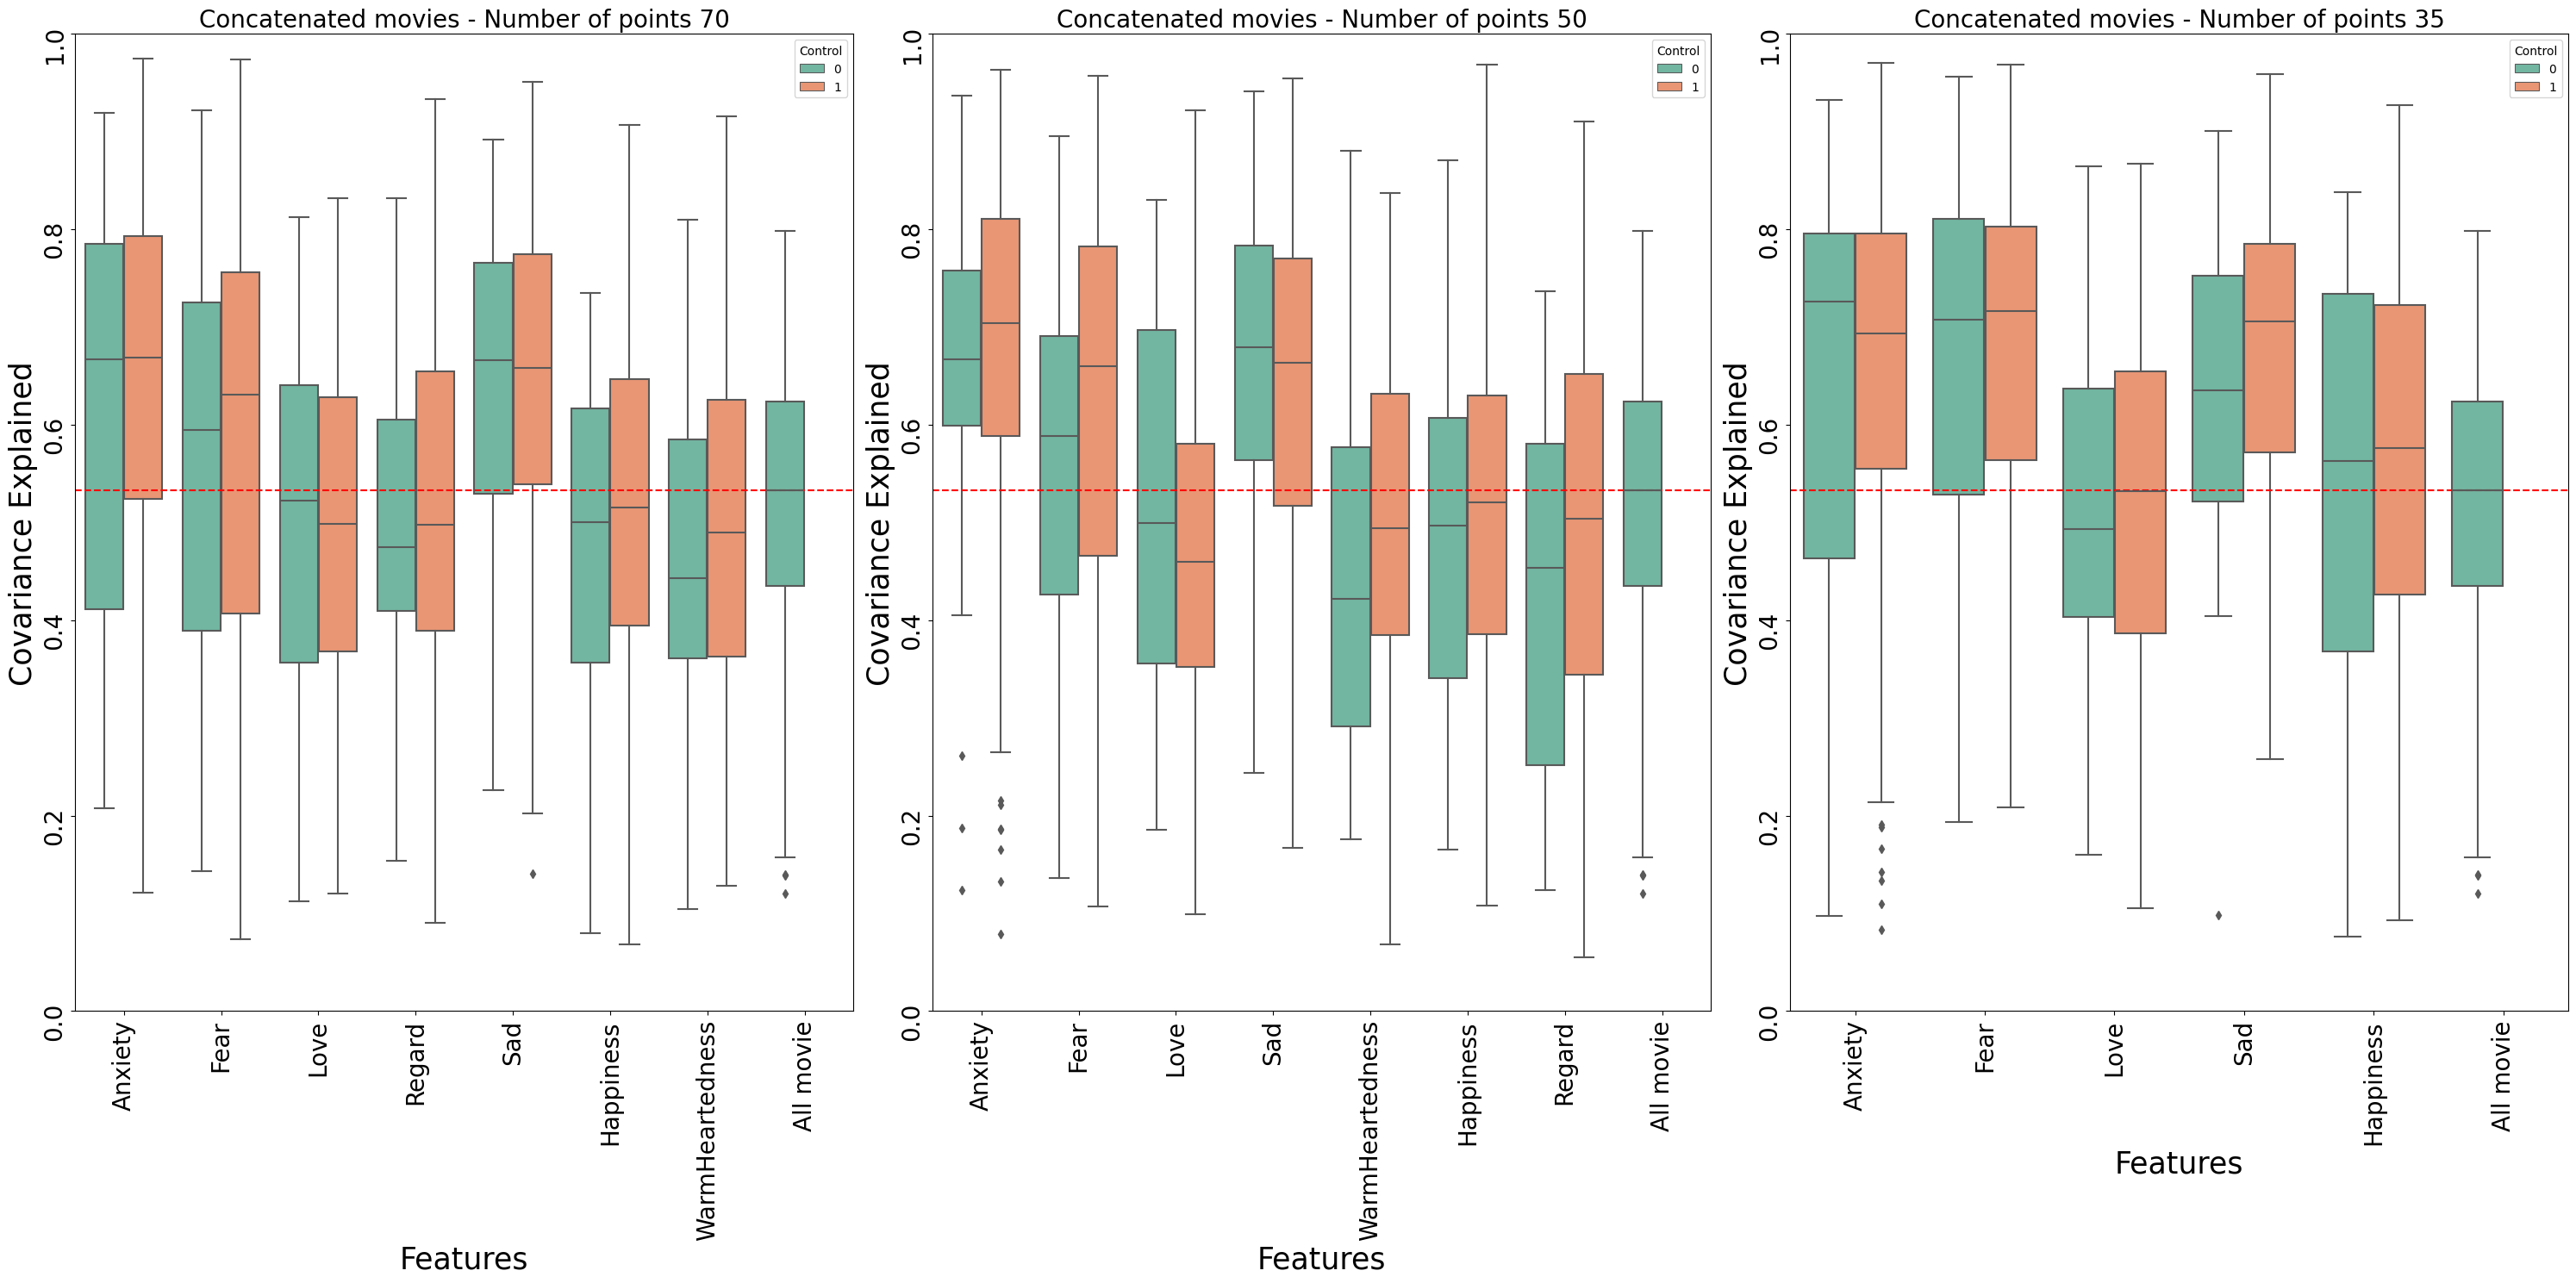

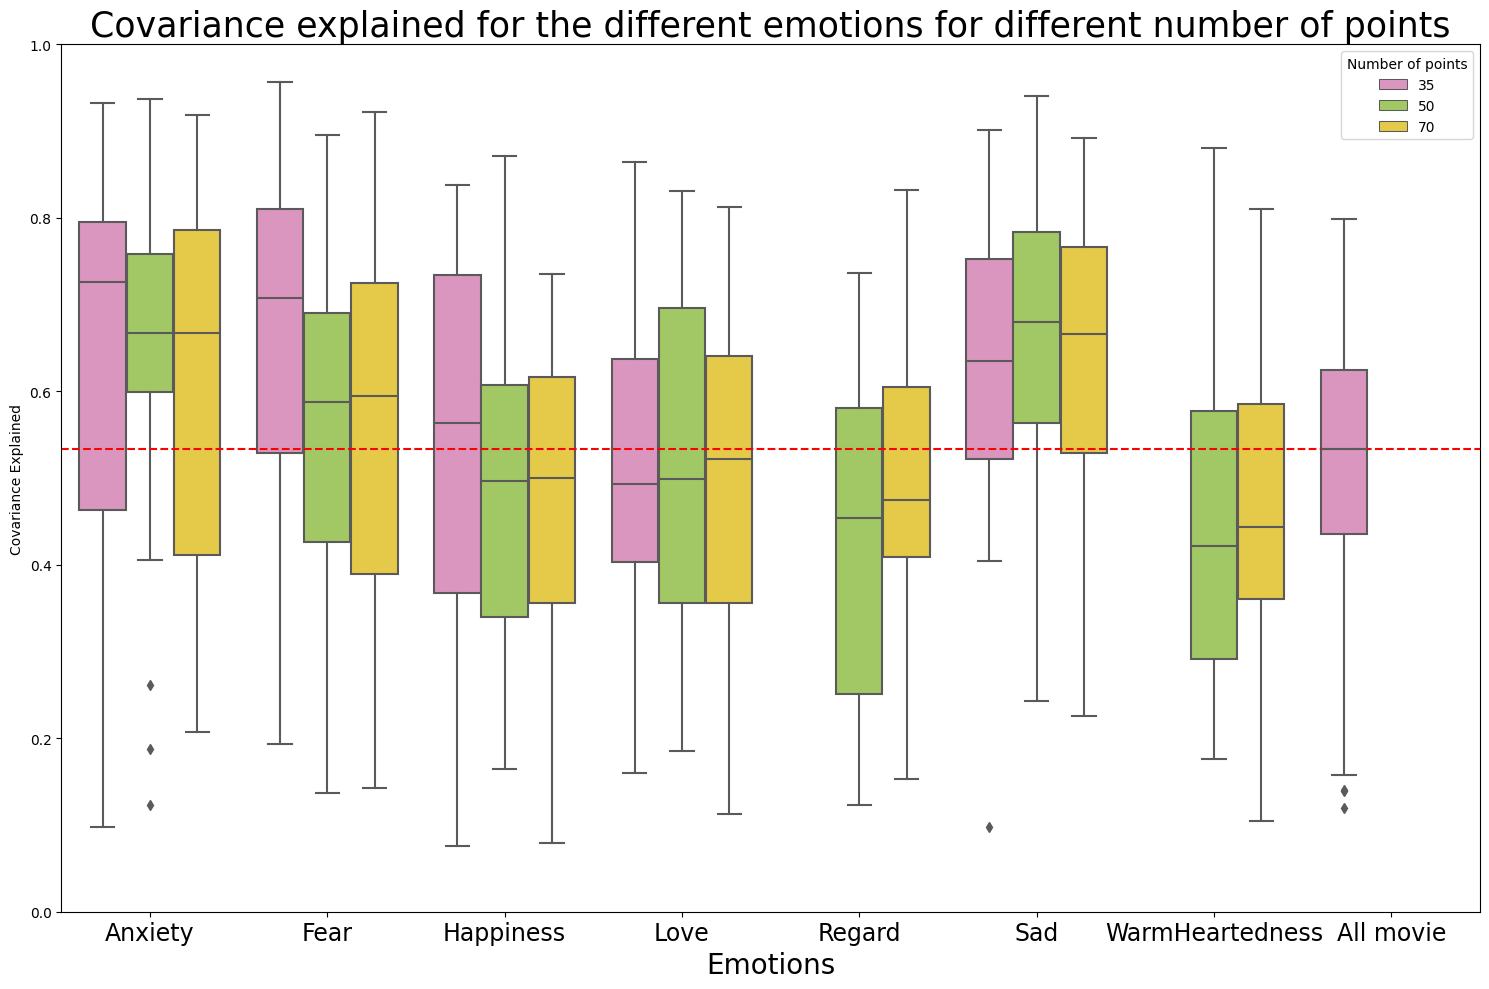

In [17]:
significant = retrieve_significant(peaks_data, data_all)
plot_peaks(significant, [70, 50, 35], on = 'Number of points')
increase_thr(significant, [70, 50, 35])

# **Scaffolds**

In [68]:
method = 'bold'

peaks_data = peaks_data[peaks_data['P-value'] != 'P-value']
peaks_data['P-value'] = peaks_data['P-value'].astype(float)
peaks_data['Covariance Explained'] = peaks_data['Covariance Explained'].astype(float)

peaks_data.to_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/{method}_peaks/PLSpeaks_emotions_single_{method}_ALL_pts.csv', index=False)

In [70]:
peaks_data

,Region,bootstrap_round,Feature,Number of points,threshold,LC,Method,Movie,Covariance Explained,P-value
0,ALL,0,Control_0_Regard,70,0.5,1,bold,Spaceman,0.495887,0.028971
1,ALL,0,Control_0_Regard,70,0.5,2,bold,Spaceman,0.228659,0.068931
2,ALL,0,Control_0_Regard,70,0.5,3,bold,Spaceman,0.102036,0.244755
3,ALL,0,Control_0_Regard,70,0.5,4,bold,Spaceman,0.062280,0.391608
4,ALL,0,Control_0_Regard,70,0.5,5,bold,Spaceman,0.041233,0.716284
...,...,...,...,...,...,...,...,...,...,...
3595,ALL,49,Regard,70,0.5,8,bold,Spaceman,0.018175,0.590410
3596,ALL,49,Regard,70,0.5,9,bold,Spaceman,0.015918,0.815185
3597,ALL,49,Regard,70,0.5,10,bold,Spaceman,0.006852,0.545455
3598,ALL,49,Regard,70,0.5,11,bold,Spaceman,0.005950,0.507493


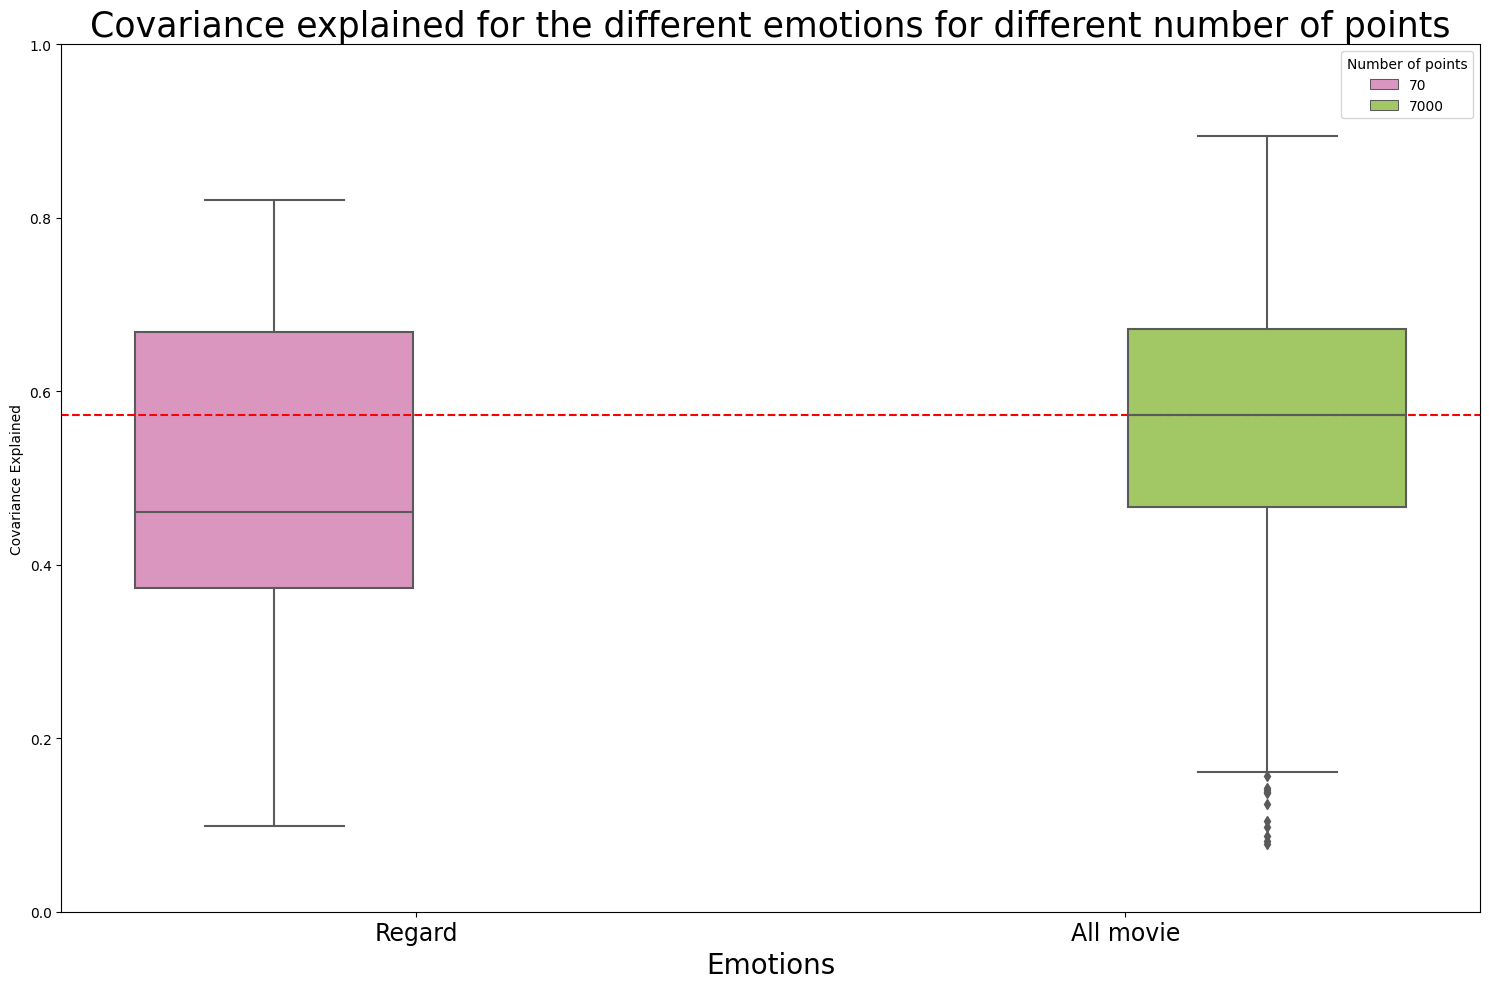

In [71]:
method = 'bold'
MOVIE = 'Spaceman'
region = 'ALL'

# Create the peaks data
peaks_data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_single_bold_ALL_pts.csv')
peaks_data = peaks_data.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'LC', 'Method', 'Movie']).last().reset_index()
peaks_data = peaks_data[(peaks_data['Movie'] == MOVIE) & (peaks_data['Region'] == region) & (peaks_data['Method'] == method)]

# Create the all movie data
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_ALL_bootstrap_results.csv', index_col=0).reset_index()
data_all['Region'] = 'ALL'
data_all['Type'] = method
data_all.reset_index(inplace=True, drop=False)
data_all['bootstrap_round'] = data_all.index // 12

# Plots
significant = retrieve_significant(peaks_data, data_all)
#plot_peaks_pts(significant, [70, 50, 35])
increase_thr(significant, [70, 50 ,35])

# **Peaks on Functional Networks**

In [ ]:
def retrieve_significant(peaks_data, data_all_movie):

    # Take the significant LC for the PLS on the peaks
    significant_peaks = peaks_data[peaks_data['P-value'] < 0.05]
    significant_peaks = significant_peaks.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold']).sum()['Covariance Explained'].reset_index()
    significant_peaks['Covariance Explained'] = significant_peaks['Covariance Explained']
    significant_peaks['Control'] = significant_peaks['Feature'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
    significant_peaks['Feature'] = significant_peaks['Feature'].apply(lambda x: x.split('_')[-1])
    significant_peaks['Feature'] = significant_peaks['Feature'].apply(lambda x: 'average_' + x if x in ['brightness', 'saturation', 'hue'] else x)

    # Take the significant LC for the PLS on all the movie
    data_all_movie['Feature'] = 'All movie'
    if 'Number of points' not in data_all_movie.columns:
        data_all_movie['Number of points'] = 7000
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Region', 'Feature', 'Number of points', 'Movie', 'bootstrap_round']).sum()['Covariance Explained'].reset_index()
    significant_all_movie['Control'] = 0
    significant = pd.concat([significant_peaks, significant_all_movie], ignore_index=True)
    significant.loc[significant['Feature'] == 'All movie', 'Number of points'] = 7000
    return significant

In [ ]:
peaks_data.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'Movie']).sum()['Covariance Explained'].reset_index()


,Region,bootstrap_round,Feature,Number of points,threshold,Movie,Covariance Explained
0,SC,0,Anxiety,35,1.35,Spaceman,1.0
1,SC,0,Anxiety,50,1.16,Spaceman,1.0
2,SC,0,Anxiety,70,0.70,Spaceman,1.0
3,SC,0,Control_0_Anxiety,35,1.35,Spaceman,1.0
4,SC,0,Control_0_Anxiety,50,1.16,Spaceman,1.0
...,...,...,...,...,...,...,...
1585,SC,29,Sad,50,1.41,Spaceman,1.0
1586,SC,29,Sad,70,1.21,Spaceman,1.0
1587,SC,29,WarmHeartedness,35,3.68,Spaceman,1.0
1588,SC,29,WarmHeartedness,50,3.23,Spaceman,1.0


VA


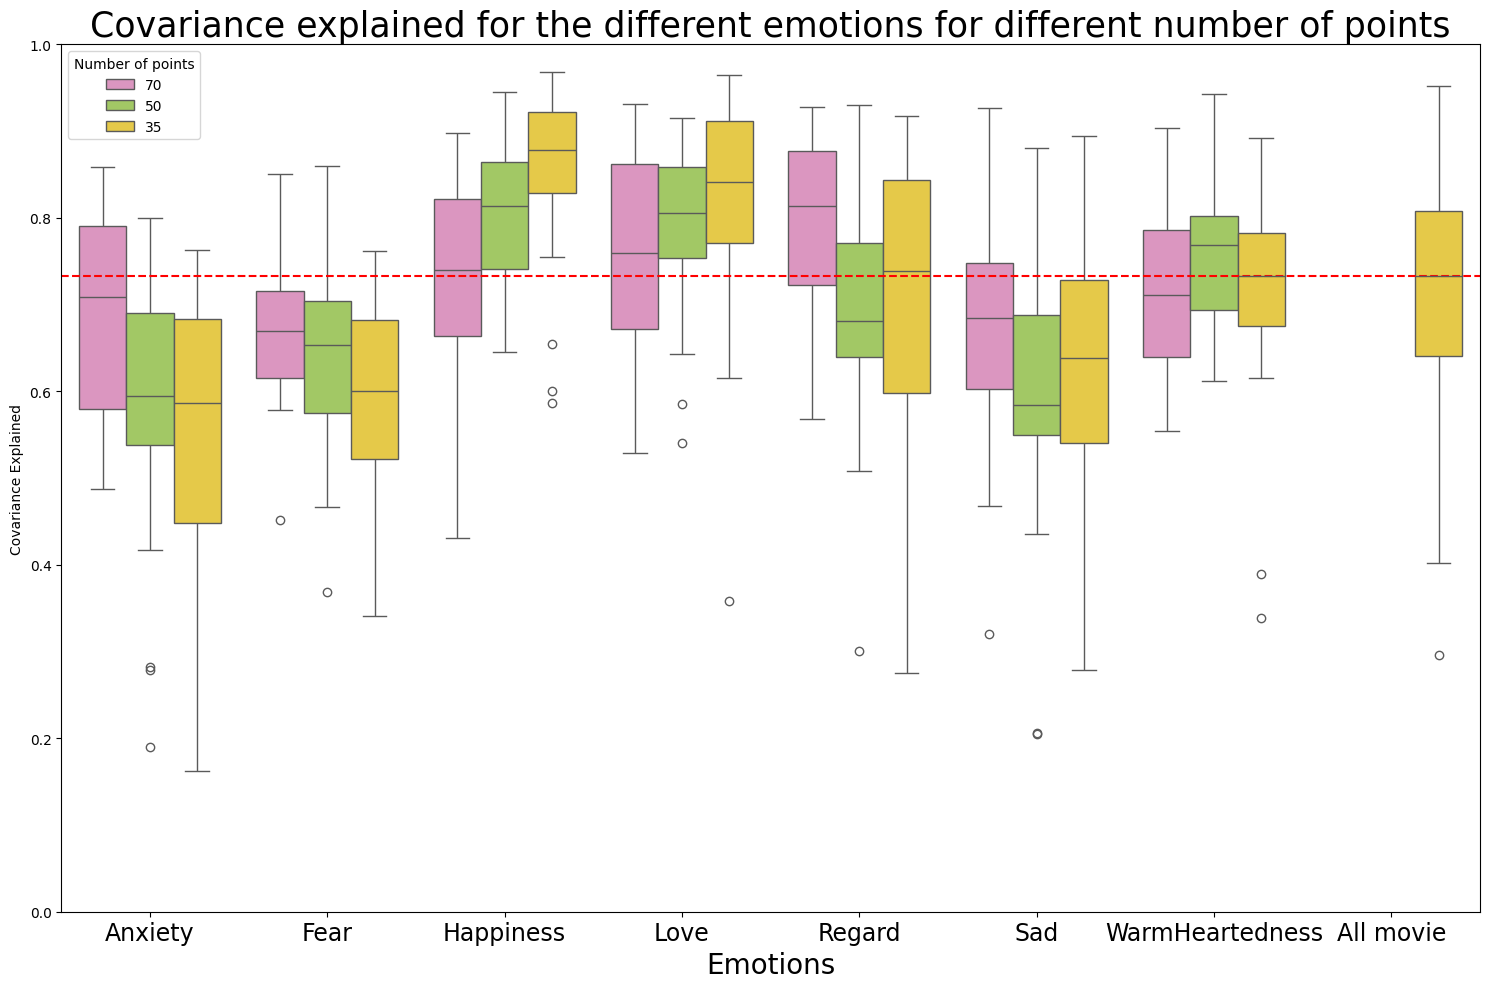

L


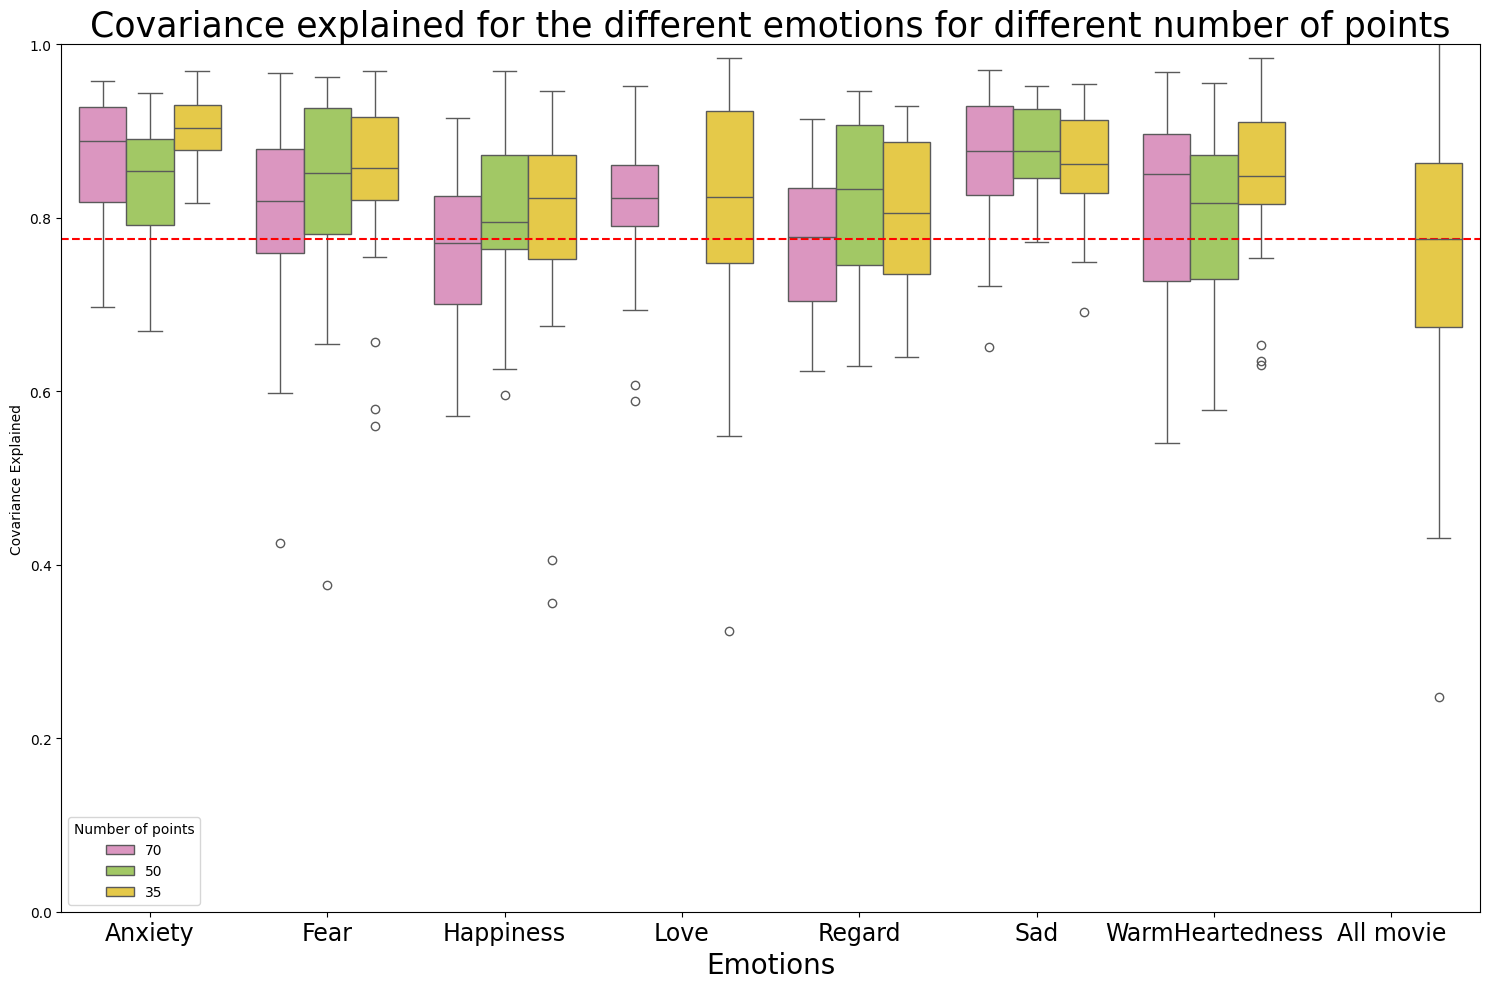

SC


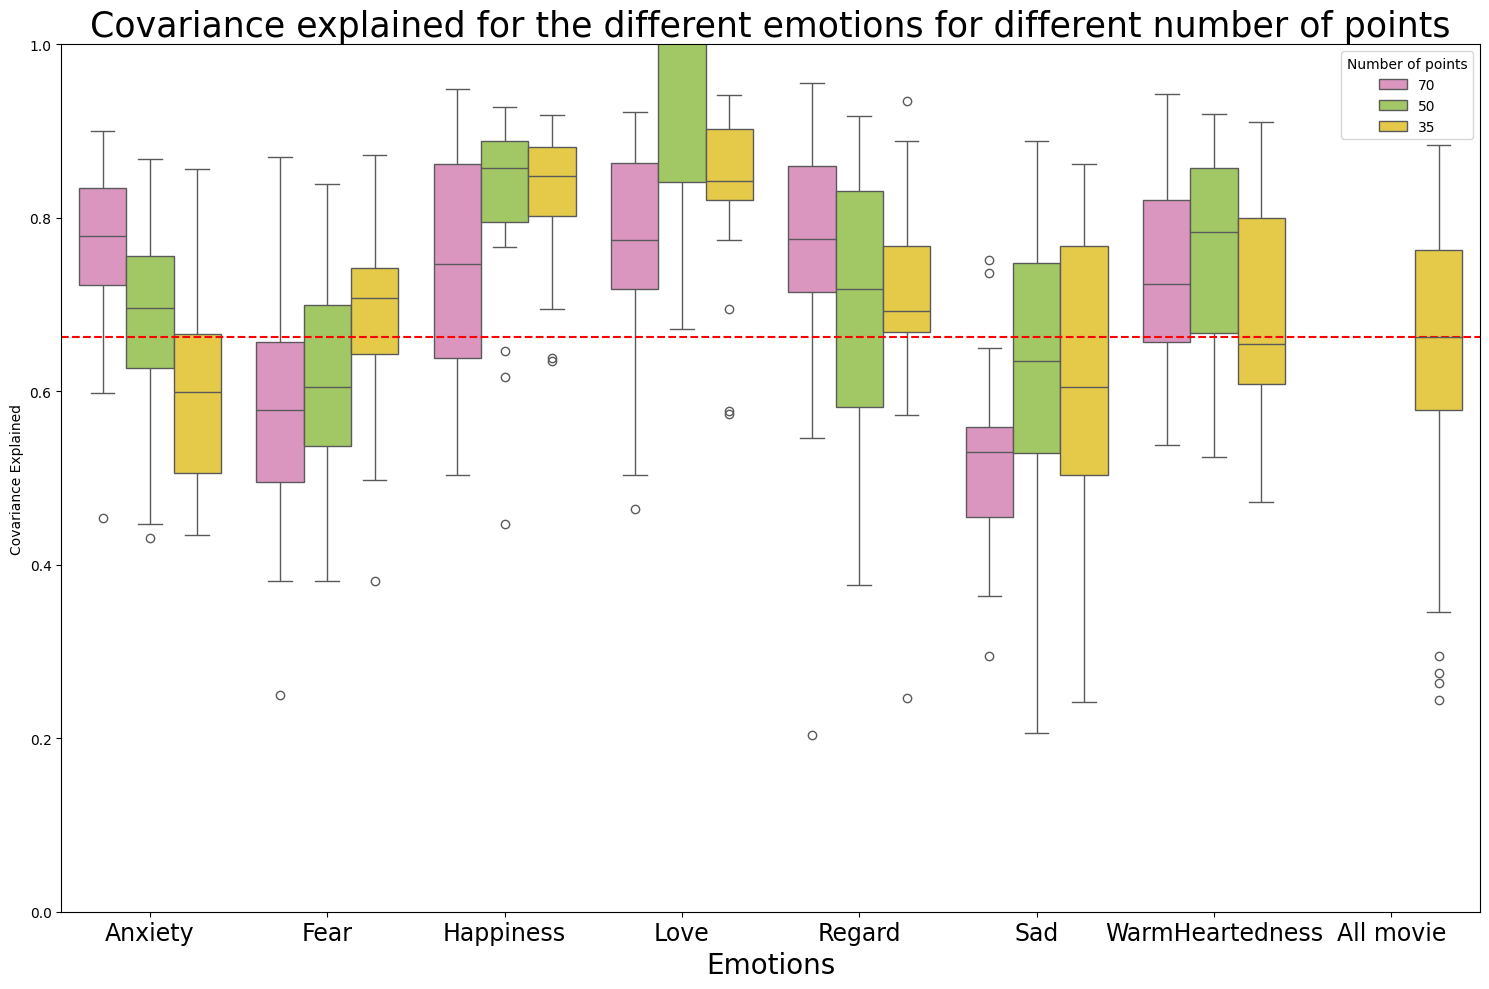

In [ ]:
MOVIE = 'Spaceman'
regions = ['VA', 'L', 'SC']

for method in ['triangles']:
    for region in regions:
        print(region)
        if method == 'scaffold':
            peaks_data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/scaffold_peaks/enrico_scaf/PLSpeaks_emotions_single_{method}_{region}_pts.csv')

        if method == 'triangles':
            peaks_data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/server_tri/PLSpeaks_emotions_single_{method}_{region}_pts.csv')
            if os.path.exists(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/enrico_tri/PLSpeaks_emotions_single_{method}_{region}_pts.csv'):
                peaks_data_enrico = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/enrico_tri/PLSpeaks_emotions_single_{method}_{region}_pts.csv')
                peaks_data = pd.concat([peaks_data, peaks_data_enrico], axis=0)
                peaks_data.to_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/PLSpeaks_emotions_single_{method}_{region}_pts.csv')

        if method == 'bold':
            peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/bold_peak/PLSpeaks_emotions_single_pts_fn.csv')
            peaks_data['Method'] = 'bold'
            peaks_data = peaks_data[peaks_data['Region'] == region]
            # peaks_data = peaks_data.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'Method', 'Movie']).last().reset_index()

        peaks_data = peaks_data[(peaks_data['Movie'] == MOVIE) & (peaks_data['Region'] == region) & (peaks_data['Method'] == method)]
        
        ########### DATA ALL ###########
        data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_{region}_bootstrap_results.csv', index_col=0).reset_index()
        data_all['Method'] = method
        data_all['Number of points'] = 7000
        data_all['Feature'] = 'All movie'
        data_all.reset_index(inplace=True, drop=False)
        data_all['bootstrap_round'] = data_all.index // 12
        data_all = data_all[data_all['Movie'] == 'Spaceman']
        data_all = data_all[data_all['P-value'] < 0.05]
        data_all = data_all.groupby(['Region', 'Feature', 'Number of points', 'Movie', 'Method', 'bootstrap_round']).sum().reset_index()
        
        significant = retrieve_significant(peaks_data, data_all)
        plot_peaks_pts(significant, [70, 50, 35])
        increase_thr(significant, [70, 50 ,35])
